In [ ]:
#import numpy as np
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import MottonenStatePreparation

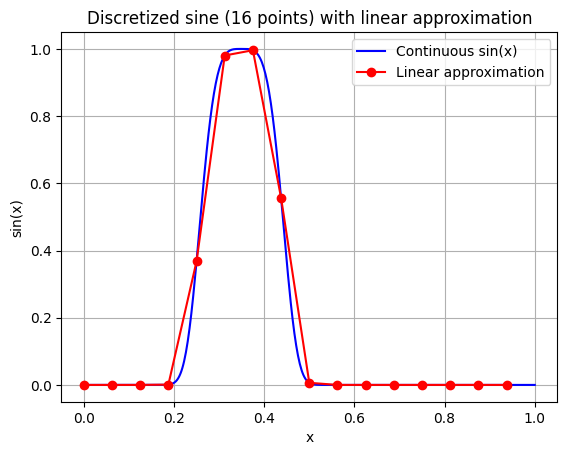

In [ ]:

n = 4 # Number of qubits

N = 2**n
x = np.linspace(0, 1, N, endpoint=False)  

#y = np.sin(x)

y = np.exp(-(10*x - 3.5)**4)

x_cont = np.linspace(0, 1, 500)  
y_cont =  np.exp(-(10*x_cont - 3.5)**4)

                
plt.plot(x_cont, y_cont, label="Continuous sin(x)", color="blue")       
plt.plot(x, y, "o-", label="Linear approximation", color="red")        

plt.xlabel("x")
plt.ylabel("sin(x)")
plt.title("Discretized sine (16 points) with linear approximation")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Some parameters fixed
dx = 1/N
Courant_number = 0.28
tau = dx * Courant_number
nu = 0.01
print(tau)

0.0175


In [ ]:
np.linalg.norm(y)

np.float64(1.5486928773324216)

In [ ]:
#random weight initialization
np.random.seed(42)
wires = list(range(n))
depth = 1
theta_0 = np.random.randn()
theta_0 = np.array(theta_0, requires_grad=True)
weights = np.random.uniform(0, 2 * np.pi, (3*n-2)*depth)
weights = np.array(weights, requires_grad=True)
param_num = weights.shape[0]

In [ ]:
def real_ansatz(weights, n, m, wires, d):
    for i in range(n, m):
        qml.RY(weights[i-n], wires=wires[i])
    for l in range(d):
        for i in range(n, m-1):
            qml.CZ(wires=[wires[i], wires[(i+1)%len(weights)]])
        for i in range(n, m):
            qml.RY(weights[i-n], wires=wires[i])
        for i in range(n, m-3):
            qml.CZ(wires=[wires[i+1], wires[(i+2)%len(weights)]])
        for i in range(n, m-1):
            qml.RY(weights[i-n], wires=wires[i])

controlled_U = qml.ctrl(real_ansatz, control=10)

In [ ]:
def initialize_state(v, m, n):
  qml.adjoint(qml.MottonenStatePreparation(v, wires=range(m, n)))
controlled_V = qml.ctrl(initialize_state, control=10)


0.45210115508135307


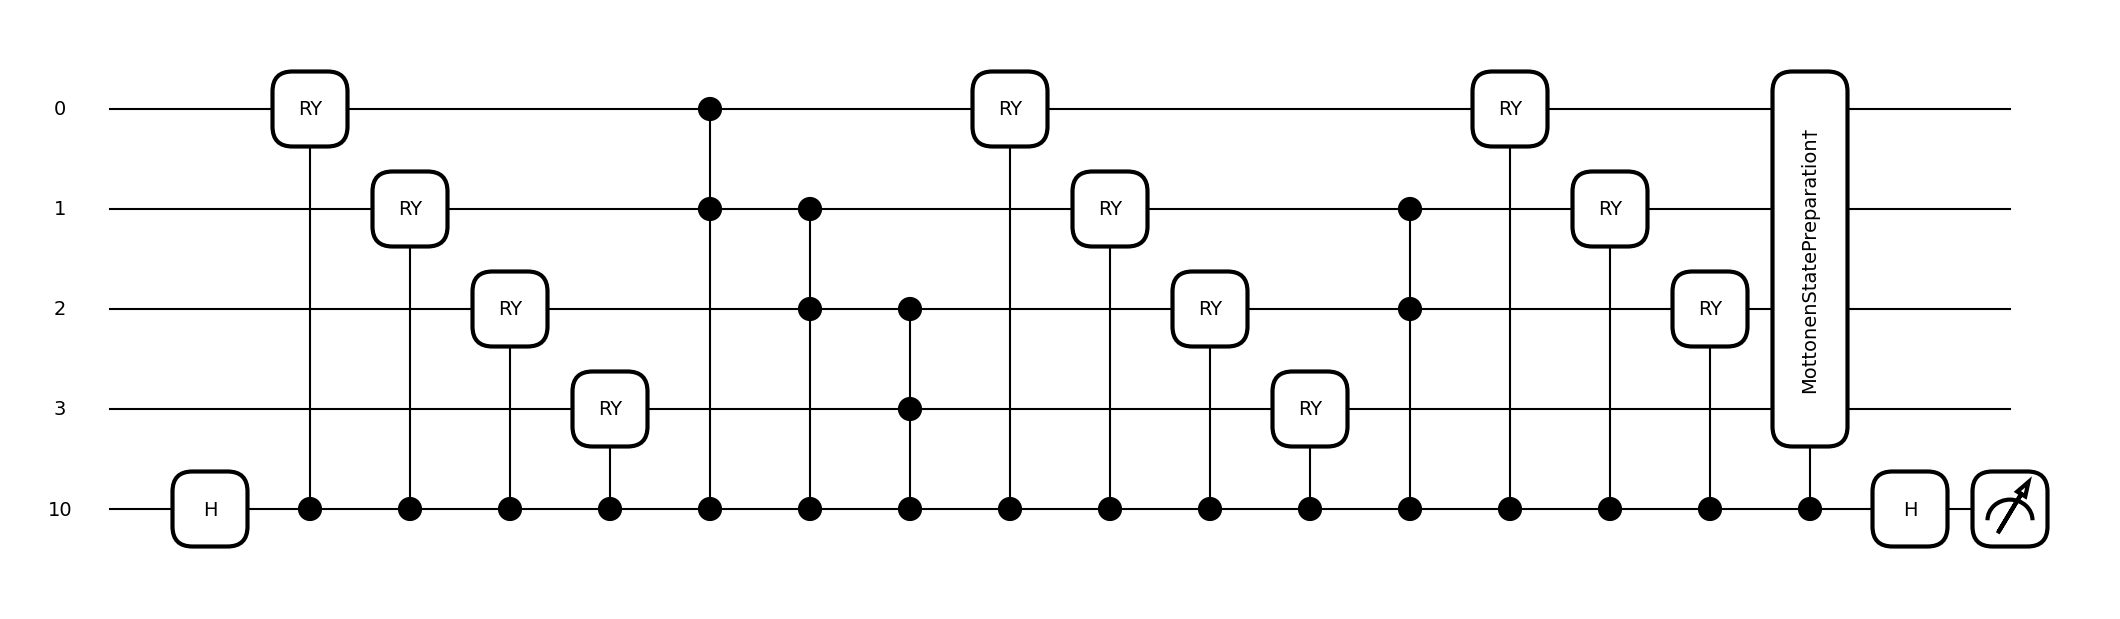

In [ ]:
dev = qml.device("default.qubit", wires=11)
y_norm = y/np.linalg.norm(y)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def prod_term(weights):
    qml.Hadamard(wires=10)
    qml.ctrl(real_ansatz, control=10)(weights, 0, 4, wires, depth)
    controlled_V(y_norm, 0, n)
    qml.Hadamard(wires=10)
    return qml.expval(qml.PauliZ(10))
    #return qml.probs(wires=wires)

test_prodterm = prod_term(weights)
qml.draw_mpl(prod_term)(weights)
print(prod_term(weights))



0.796783148028009
0.21138708239273035
0.1615881356409798


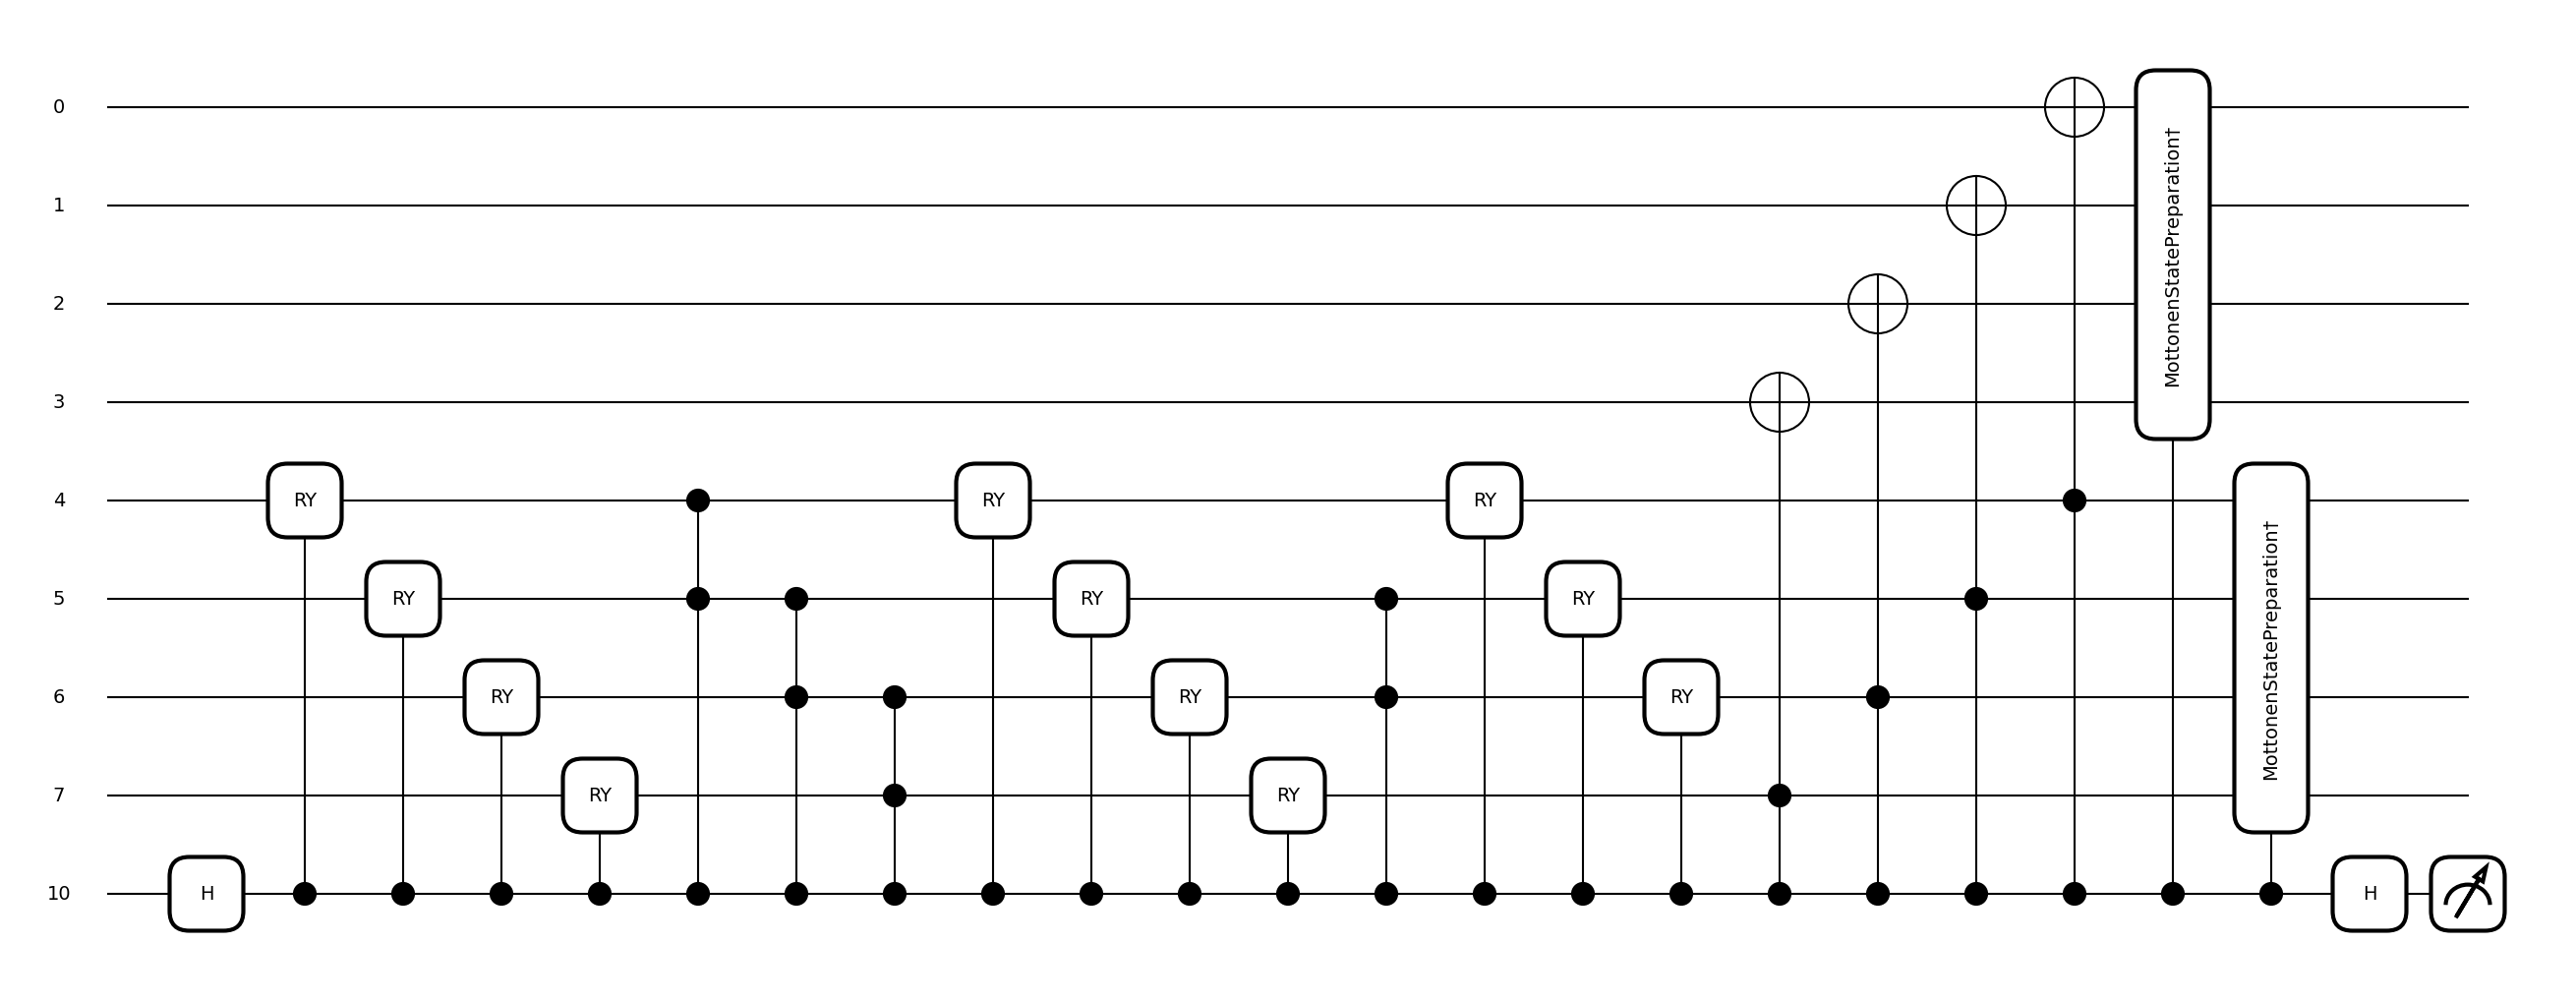

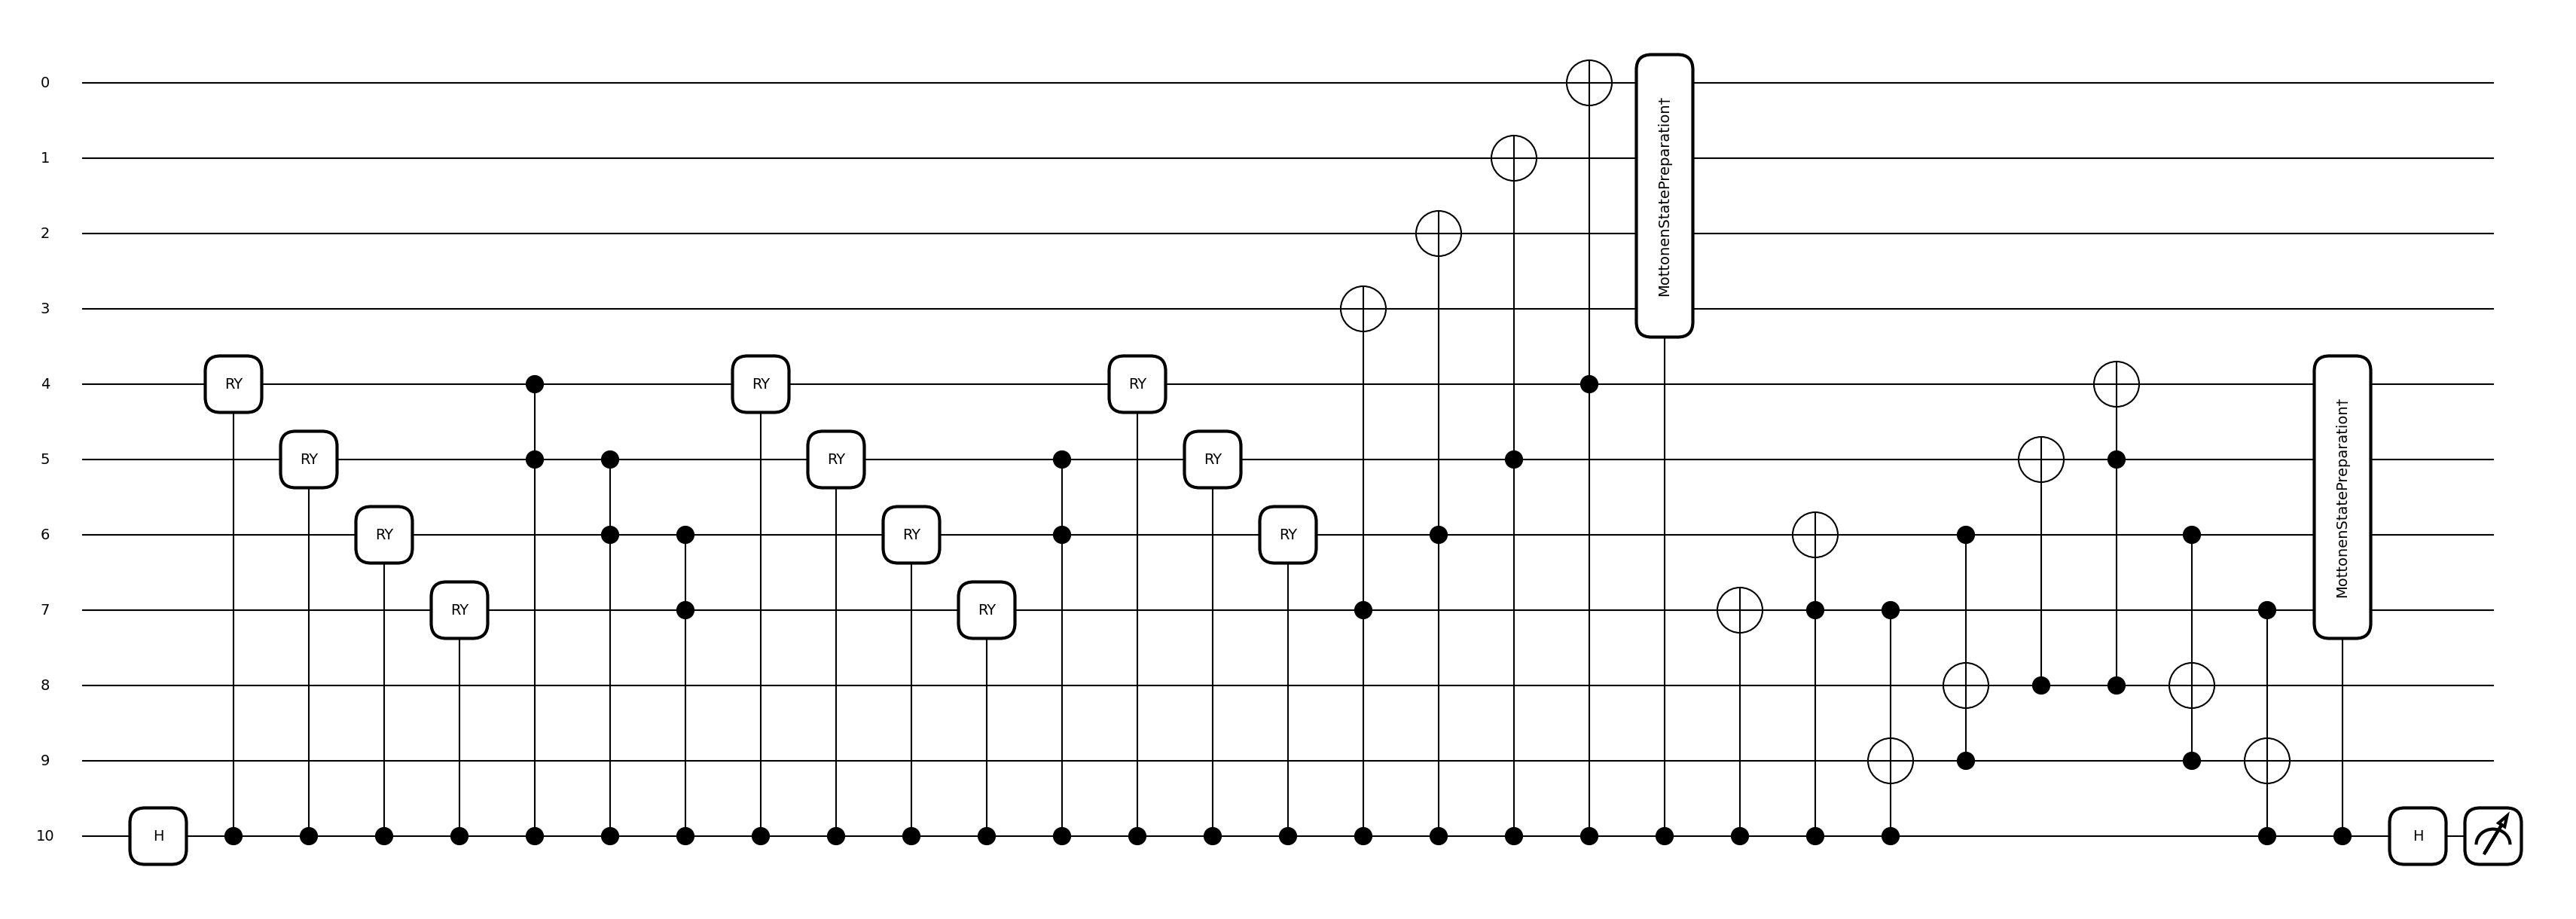

In [ ]:
y_norm = y/np.linalg.norm(y)
# Calculating derivative using adder
def toffoli_ladder():
    qml.Toffoli(wires=[10, 7, 3])
    qml.Toffoli(wires=[10, 6, 2])
    qml.Toffoli(wires=[10, 5, 1])
    qml.Toffoli(wires=[10, 4, 0])
def cnot_shift():
    qml.CNOT(wires=[10, 7])
    qml.Toffoli(wires=[10, 7, 6])
    qml.Toffoli(wires=[10, 7, 9])
    qml.Toffoli(wires=[9, 6, 8])
    qml.CNOT(wires=[8, 5])
    qml.Toffoli(wires=[8, 5, 4])
    qml.Toffoli(wires=[9, 6, 8])
    qml.Toffoli(wires=[10, 7, 9])

#@qml.qnode(dev)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def first_term(weights):
    qml.Hadamard(wires=10)
    #controlled_U(weights, 4, 8,list(range(0, 11)) , depth)
    qml.ctrl(real_ansatz, control=10)(weights, 4, 8, list(range(0, 11)), depth)
    toffoli_ladder()
    controlled_V(y_norm, 0, 4)
    controlled_V(y_norm, 4, 8)
    qml.Hadamard(wires=10)
    return qml.expval(qml.PauliZ(10))

qml.draw_mpl(first_term)(weights)

#@qml.qnode(dev)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def second_term(weights):
    qml.Hadamard(wires=10)
    controlled_U(weights, 4, 8, list(range(0, 11)), depth)
    toffoli_ladder()
    controlled_V(y_norm, 0, 4)
    cnot_shift()
    controlled_V(y_norm, 4, 8)
    qml.Hadamard(wires=10)
    return qml.expval(qml.PauliZ(10))
qml.draw_mpl(second_term)(weights)

yk_yk_uk = first_term(weights)
yk_yk_uk_minus1 = second_term(weights)

def quantum_grad(weights):
    yk_yk_uk = first_term(weights)
    yk_yk_uk_minus1 = second_term(weights)
    result = (yk_yk_uk - yk_yk_uk_minus1)/dx
    return result
print(quantum_grad(weights))
print(yk_yk_uk)
print(yk_yk_uk_minus1)


In [ ]:
# CIRCUITS FOR NABLA
def cnot_shift_B():
    qml.CNOT(wires=[6, 3])
    qml.Toffoli(wires=[6, 3, 2])
    qml.Toffoli(wires=[6, 3, 5])
    qml.Toffoli(wires=[5, 2, 4])
    qml.CNOT(wires=[4, 1])
    qml.Toffoli(wires=[4, 1, 0])
    qml.Toffoli(wires=[5, 2, 4])
    qml.Toffoli(wires=[6, 3, 5])
controlled_U_NO = qml.ctrl(real_ansatz, control=4)
controlled_U_yes = qml.ctrl(real_ansatz, control=6)
controlled_V_NO = qml.ctrl(initialize_state, control=4)
controlled_V_yes = qml.ctrl(initialize_state, control=6)
#@qml.qnode(dev)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def circuit_nabla_NOSHIFT(weights): #like circuit A, gives us u_k * u_k
    qml.Hadamard(wires=4)
    controlled_U_NO(weights, 0, 4, list(range(0,4)), depth)
    controlled_V_NO(y_norm, 0, 4)
    qml.Hadamard(wires=4)
    return qml.expval(qml.PauliZ(4))
ukuk = circuit_nabla_NOSHIFT(weights)
print("u_k * u_k: ", ukuk, "\n")

#@qml.qnode(dev)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def circuit_nabla_shift_1(weights): #like circuit B, gives us u_k * u_(k-1)
    qml.Hadamard(wires=6)
    controlled_U_yes(weights, 0, 4, list(range(0,4)), depth)
    cnot_shift_B()
    controlled_V_yes(y_norm, 0, 4)
    qml.Hadamard(wires=6)
    return qml.expval(qml.PauliZ(6))
print("u_k * u_(k-1): ", circuit_nabla_shift_1(weights), "\n")

#@qml.qnode(dev)
@qml.qnode(dev, diff_method="adjoint", interface="autograd")
def circuit_nabla_shift_2(weights): #like circuit B, gives us u_k * u_(k-2)
    qml.Hadamard(wires=6)
    controlled_U_yes(weights, 0, 4, list(range(0,4)), depth)
    cnot_shift_B()
    cnot_shift_B()
    controlled_V_yes(y_norm, 0, 4)
    qml.Hadamard(wires=6)
    return qml.expval(qml.PauliZ(6))
print("u_k * u_(k-2): ", circuit_nabla_shift_2(weights), "\n")


#ACTUALLY BUILDING NABLA, quantum here, classical below
uk_uk_minus1 = circuit_nabla_shift_1(weights)
uk_uk_minus2 = circuit_nabla_shift_2(weights)
#quantum_nabla = (-2*uk_uk_minus2 + ukuk + uk_uk_minus1)/(dx**2)
def quantum_nabla(weights):
    result = (circuit_nabla_shift_2(weights) + circuit_nabla_NOSHIFT(weights) - 2 * circuit_nabla_shift_1(weights))/(dx**2)
    return result


print("Quantum nabla: ", quantum_nabla(weights), "\n")


u_k * u_k:  0.45210115508135323 

u_k * u_(k-1):  0.4795895748393573 

u_k * u_(k-2):  0.5960525674232426 

Quantum nabla:  22.77749064342558 



In [ ]:
dev_check = qml.device("default.qubit", wires=n)
@qml.qnode(dev_check)
def double_check():
    real_ansatz(weights, 0, 4, wires, depth)
    return qml.state()
print(np.dot(double_check(), y/np.linalg.norm(y)))  # should be close to prod_term() result

#checking classical grad
solution = double_check()
diff_y = np.zeros(len(y_norm))
for i in range(len(y_norm)):
    diff_y[i] = y_norm[i] - y_norm[i-1]
grad = diff_y/dx
print(np.dot(solution*y_norm, grad))
print(np.dot(y_norm, y_norm*solution))
print(np.dot(y_norm, np.roll(y_norm*solution, -1)))
    

(0.4521011550802164+0j)
(0.7967831480278711+0j)
(0.21138708239273035+0j)
(0.16158813564098845+0j)


In [ ]:
#Classical nabla

print("Classical u_k * u_k: ", np.dot(solution, y_norm), "\n")
print("Classical u_k * u_(k-1): ", np.dot(y_norm, np.roll(solution, -1)), "\n")
print("Classical u_k * u_(k-2): ", np.dot(y_norm, np.roll(solution, -2)), "\n")
diff_u2 = np.zeros(len(y))
for i in range(len(y)):
    diff_u2 [i] = y_norm[i] - 2 * y_norm[i-1] + y_norm [i-2]
lap_u =  diff_u2/(dx**2)
print("Classical nabla: ", np.dot(solution, lap_u), "\n")



Classical u_k * u_k:  (0.4521011550802164+0j) 

Classical u_k * u_(k-1):  (0.47958957483878806+0j) 

Classical u_k * u_(k-2):  (0.5960525674250857+0j) 

Classical nabla:  (22.77749064389785+0j) 



In [ ]:
all_weights = np.concatenate(([theta_0], weights))
all_weights = np.array(all_weights, requires_grad=True)
print(all_weights)
print(all_weights.shape)
print(type(all_weights))

[0.49671415 4.59925358 3.76148219 0.98029403 0.98014248 0.3649501
 5.44234523 3.77691701 4.44895122 0.12933619 6.09412333]
(11,)
<class 'pennylane.numpy.tensor.tensor'>


In [ ]:
the_norm = np.linalg.norm(y)
def cost_function(all_weights):
    theta_0 = all_weights[0]
    weights = all_weights[1:]
    #theta_0_tilda = np.linalg.norm(y)
    theta_0_tilda = the_norm
    constante = theta_0_tilda**2 #+ tau**2*nu**2
    result = theta_0**2 - 2*(theta_0 * theta_0_tilda * (prod_term(weights) - tau*theta_0_tilda * quantum_grad(weights)  + tau * nu * quantum_nabla(weights))) + constante
    return result
c = cost_function(all_weights)
print("Cost function: ", c)
print(type(c))
print(c.shape)


Cost function:  1.9767008945562978
<class 'pennylane.numpy.tensor.tensor'>
()


In [ ]:
d = cost_function(all_weights)
print(d)

1.9767008945562978


In [ ]:
from tqdm import tqdm

In [ ]:
lr = 1e-2
for i in tqdm(range(2)):
    cost_val = cost_function(all_weights)
    grads = qml.grad(cost_function)(all_weights)
    print(grads)  # compute gradient w.r.t all_weights
    all_weights = all_weights - lr * grads          # gradient descent step

    if i % 10 == 0:
        print(f"Step {i}: cost = {cost_val:.6f}")

  0%|          | 1/10000 [00:01<3:04:56,  1.11s/it]

Step 0: cost = 1.976701


  0%|          | 11/10000 [00:11<2:55:00,  1.05s/it]

Step 10: cost = 1.954254


  0%|          | 21/10000 [00:22<2:55:12,  1.05s/it]

Step 20: cost = 1.933688


  0%|          | 31/10000 [00:32<2:55:27,  1.06s/it]

Step 30: cost = 1.914370


  0%|          | 41/10000 [00:43<2:55:12,  1.06s/it]

Step 40: cost = 1.895770


  1%|          | 51/10000 [00:53<2:54:53,  1.05s/it]

Step 50: cost = 1.877412


  1%|          | 61/10000 [01:04<2:54:48,  1.06s/it]

Step 60: cost = 1.858855


  1%|          | 71/10000 [01:14<2:54:29,  1.05s/it]

Step 70: cost = 1.839685


  1%|          | 81/10000 [01:25<2:54:24,  1.05s/it]

Step 80: cost = 1.819529


  1%|          | 91/10000 [01:36<2:54:18,  1.06s/it]

Step 90: cost = 1.798059


  1%|          | 101/10000 [01:46<2:54:01,  1.05s/it]

Step 100: cost = 1.775018


  1%|          | 111/10000 [01:57<2:53:51,  1.05s/it]

Step 110: cost = 1.750244


  1%|          | 121/10000 [02:07<2:53:49,  1.06s/it]

Step 120: cost = 1.723691


  1%|▏         | 131/10000 [02:18<2:53:42,  1.06s/it]

Step 130: cost = 1.695452


  1%|▏         | 141/10000 [02:28<2:53:24,  1.06s/it]

Step 140: cost = 1.665771


  2%|▏         | 151/10000 [02:39<2:53:14,  1.06s/it]

Step 150: cost = 1.635035


  2%|▏         | 161/10000 [02:50<2:53:08,  1.06s/it]

Step 160: cost = 1.603744


  2%|▏         | 171/10000 [03:00<2:53:00,  1.06s/it]

Step 170: cost = 1.572461


  2%|▏         | 181/10000 [03:11<2:52:48,  1.06s/it]

Step 180: cost = 1.541744


  2%|▏         | 191/10000 [03:21<2:52:38,  1.06s/it]

Step 190: cost = 1.512087


  2%|▏         | 201/10000 [03:32<2:52:31,  1.06s/it]

Step 200: cost = 1.483869


  2%|▏         | 211/10000 [03:42<2:52:10,  1.06s/it]

Step 210: cost = 1.457335


  2%|▏         | 221/10000 [03:53<2:52:02,  1.06s/it]

Step 220: cost = 1.432603


  2%|▏         | 231/10000 [04:04<2:51:59,  1.06s/it]

Step 230: cost = 1.409688


  2%|▏         | 241/10000 [04:14<2:51:44,  1.06s/it]

Step 240: cost = 1.388539


  3%|▎         | 251/10000 [04:25<2:51:25,  1.06s/it]

Step 250: cost = 1.369066


  3%|▎         | 261/10000 [04:35<2:51:10,  1.05s/it]

Step 260: cost = 1.351169


  3%|▎         | 271/10000 [04:46<2:50:50,  1.05s/it]

Step 270: cost = 1.334745


  3%|▎         | 281/10000 [04:56<2:50:58,  1.06s/it]

Step 280: cost = 1.319697


  3%|▎         | 291/10000 [05:07<2:50:35,  1.05s/it]

Step 290: cost = 1.305938


  3%|▎         | 301/10000 [05:17<2:50:32,  1.05s/it]

Step 300: cost = 1.293382


  3%|▎         | 311/10000 [05:28<2:50:16,  1.05s/it]

Step 310: cost = 1.281952


  3%|▎         | 321/10000 [05:39<2:49:57,  1.05s/it]

Step 320: cost = 1.271571


  3%|▎         | 331/10000 [05:49<2:49:51,  1.05s/it]

Step 330: cost = 1.262163


  3%|▎         | 341/10000 [06:00<2:49:45,  1.05s/it]

Step 340: cost = 1.253656


  4%|▎         | 351/10000 [06:10<2:49:32,  1.05s/it]

Step 350: cost = 1.245981


  4%|▎         | 361/10000 [06:21<2:49:34,  1.06s/it]

Step 360: cost = 1.239068


  4%|▎         | 371/10000 [06:31<2:49:16,  1.05s/it]

Step 370: cost = 1.232855


  4%|▍         | 381/10000 [06:42<2:49:14,  1.06s/it]

Step 380: cost = 1.227278


  4%|▍         | 391/10000 [06:52<2:48:55,  1.05s/it]

Step 390: cost = 1.222280


  4%|▍         | 401/10000 [07:03<2:48:52,  1.06s/it]

Step 400: cost = 1.217808


  4%|▍         | 411/10000 [07:14<2:48:41,  1.06s/it]

Step 410: cost = 1.213810


  4%|▍         | 421/10000 [07:24<2:48:29,  1.06s/it]

Step 420: cost = 1.210240


  4%|▍         | 431/10000 [07:35<2:48:14,  1.05s/it]

Step 430: cost = 1.207056


  4%|▍         | 441/10000 [07:45<2:47:56,  1.05s/it]

Step 440: cost = 1.204218


  5%|▍         | 451/10000 [07:56<2:47:48,  1.05s/it]

Step 450: cost = 1.201691


  5%|▍         | 461/10000 [08:06<2:47:26,  1.05s/it]

Step 460: cost = 1.199442


  5%|▍         | 471/10000 [08:17<2:47:40,  1.06s/it]

Step 470: cost = 1.197442


  5%|▍         | 481/10000 [08:27<2:47:30,  1.06s/it]

Step 480: cost = 1.195664


  5%|▍         | 491/10000 [08:38<2:47:18,  1.06s/it]

Step 490: cost = 1.194084


  5%|▌         | 501/10000 [08:49<2:47:14,  1.06s/it]

Step 500: cost = 1.192682


  5%|▌         | 511/10000 [08:59<2:46:51,  1.06s/it]

Step 510: cost = 1.191436


  5%|▌         | 521/10000 [09:10<2:46:42,  1.06s/it]

Step 520: cost = 1.190331


  5%|▌         | 531/10000 [09:20<2:46:30,  1.06s/it]

Step 530: cost = 1.189351


  5%|▌         | 541/10000 [09:31<2:46:10,  1.05s/it]

Step 540: cost = 1.188482


  6%|▌         | 551/10000 [09:41<2:46:06,  1.05s/it]

Step 550: cost = 1.187711


  6%|▌         | 561/10000 [09:52<2:45:59,  1.06s/it]

Step 560: cost = 1.187027


  6%|▌         | 571/10000 [10:02<2:45:53,  1.06s/it]

Step 570: cost = 1.186421


  6%|▌         | 581/10000 [10:13<2:45:29,  1.05s/it]

Step 580: cost = 1.185885


  6%|▌         | 591/10000 [10:24<2:45:30,  1.06s/it]

Step 590: cost = 1.185409


  6%|▌         | 601/10000 [10:34<2:45:22,  1.06s/it]

Step 600: cost = 1.184987


  6%|▌         | 611/10000 [10:45<2:45:08,  1.06s/it]

Step 610: cost = 1.184614


  6%|▌         | 621/10000 [10:55<2:45:01,  1.06s/it]

Step 620: cost = 1.184283


  6%|▋         | 631/10000 [11:06<2:44:47,  1.06s/it]

Step 630: cost = 1.183991


  6%|▋         | 641/10000 [11:16<2:44:38,  1.06s/it]

Step 640: cost = 1.183731


  7%|▋         | 651/10000 [11:27<2:44:30,  1.06s/it]

Step 650: cost = 1.183501


  7%|▋         | 661/10000 [11:38<2:44:23,  1.06s/it]

Step 660: cost = 1.183298


  7%|▋         | 671/10000 [11:48<2:43:57,  1.05s/it]

Step 670: cost = 1.183118


  7%|▋         | 681/10000 [11:59<2:43:53,  1.06s/it]

Step 680: cost = 1.182958


  7%|▋         | 691/10000 [12:09<2:43:42,  1.06s/it]

Step 690: cost = 1.182817


  7%|▋         | 701/10000 [12:20<2:43:30,  1.05s/it]

Step 700: cost = 1.182692


  7%|▋         | 711/10000 [12:30<2:43:20,  1.06s/it]

Step 710: cost = 1.182581


  7%|▋         | 721/10000 [12:41<2:43:11,  1.06s/it]

Step 720: cost = 1.182483


  7%|▋         | 731/10000 [12:51<2:42:58,  1.05s/it]

Step 730: cost = 1.182397


  7%|▋         | 741/10000 [13:02<2:42:47,  1.05s/it]

Step 740: cost = 1.182320


  8%|▊         | 751/10000 [13:13<2:42:31,  1.05s/it]

Step 750: cost = 1.182252


  8%|▊         | 761/10000 [13:23<2:42:22,  1.05s/it]

Step 760: cost = 1.182192


  8%|▊         | 771/10000 [13:34<2:42:18,  1.06s/it]

Step 770: cost = 1.182138


  8%|▊         | 781/10000 [13:44<2:41:59,  1.05s/it]

Step 780: cost = 1.182091


  8%|▊         | 791/10000 [13:55<2:41:55,  1.05s/it]

Step 790: cost = 1.182049


  8%|▊         | 801/10000 [14:05<2:41:36,  1.05s/it]

Step 800: cost = 1.182012


  8%|▊         | 811/10000 [14:16<2:41:37,  1.06s/it]

Step 810: cost = 1.181980


  8%|▊         | 821/10000 [14:26<2:41:29,  1.06s/it]

Step 820: cost = 1.181951


  8%|▊         | 831/10000 [14:37<2:41:10,  1.05s/it]

Step 830: cost = 1.181925


  8%|▊         | 841/10000 [14:48<2:41:02,  1.06s/it]

Step 840: cost = 1.181902


  9%|▊         | 851/10000 [14:58<2:40:54,  1.06s/it]

Step 850: cost = 1.181882


  9%|▊         | 861/10000 [15:09<2:40:38,  1.05s/it]

Step 860: cost = 1.181865


  9%|▊         | 871/10000 [15:19<2:40:18,  1.05s/it]

Step 870: cost = 1.181849


  9%|▉         | 881/10000 [15:30<2:40:14,  1.05s/it]

Step 880: cost = 1.181835


  9%|▉         | 891/10000 [15:40<2:40:07,  1.05s/it]

Step 890: cost = 1.181822


  9%|▉         | 901/10000 [15:51<2:40:01,  1.06s/it]

Step 900: cost = 1.181812


  9%|▉         | 911/10000 [16:01<2:39:46,  1.05s/it]

Step 910: cost = 1.181802


  9%|▉         | 921/10000 [16:12<2:39:49,  1.06s/it]

Step 920: cost = 1.181793


  9%|▉         | 931/10000 [16:23<2:39:23,  1.05s/it]

Step 930: cost = 1.181786


  9%|▉         | 941/10000 [16:33<2:39:22,  1.06s/it]

Step 940: cost = 1.181779


 10%|▉         | 951/10000 [16:44<2:39:14,  1.06s/it]

Step 950: cost = 1.181773


 10%|▉         | 961/10000 [16:54<2:39:18,  1.06s/it]

Step 960: cost = 1.181768


 10%|▉         | 971/10000 [17:05<2:38:54,  1.06s/it]

Step 970: cost = 1.181763


 10%|▉         | 981/10000 [17:15<2:38:37,  1.06s/it]

Step 980: cost = 1.181759


 10%|▉         | 991/10000 [17:26<2:38:27,  1.06s/it]

Step 990: cost = 1.181755


 10%|█         | 1001/10000 [17:36<2:38:16,  1.06s/it]

Step 1000: cost = 1.181752


 10%|█         | 1011/10000 [17:47<2:38:08,  1.06s/it]

Step 1010: cost = 1.181749


 10%|█         | 1021/10000 [17:58<2:38:00,  1.06s/it]

Step 1020: cost = 1.181747


 10%|█         | 1031/10000 [18:08<2:37:48,  1.06s/it]

Step 1030: cost = 1.181745


 10%|█         | 1041/10000 [18:19<2:37:35,  1.06s/it]

Step 1040: cost = 1.181743


 11%|█         | 1051/10000 [18:29<2:37:30,  1.06s/it]

Step 1050: cost = 1.181741


 11%|█         | 1061/10000 [18:40<2:37:13,  1.06s/it]

Step 1060: cost = 1.181739


 11%|█         | 1071/10000 [18:50<2:36:52,  1.05s/it]

Step 1070: cost = 1.181738


 11%|█         | 1081/10000 [19:01<2:36:55,  1.06s/it]

Step 1080: cost = 1.181737


 11%|█         | 1091/10000 [19:12<2:36:41,  1.06s/it]

Step 1090: cost = 1.181736


 11%|█         | 1101/10000 [19:22<2:36:24,  1.05s/it]

Step 1100: cost = 1.181735


 11%|█         | 1111/10000 [19:33<2:36:05,  1.05s/it]

Step 1110: cost = 1.181734


 11%|█         | 1121/10000 [19:43<2:36:01,  1.05s/it]

Step 1120: cost = 1.181733


 11%|█▏        | 1131/10000 [19:54<2:35:55,  1.05s/it]

Step 1130: cost = 1.181732


 11%|█▏        | 1141/10000 [20:04<2:35:48,  1.06s/it]

Step 1140: cost = 1.181732


 12%|█▏        | 1151/10000 [20:15<2:35:41,  1.06s/it]

Step 1150: cost = 1.181731


 12%|█▏        | 1161/10000 [20:25<2:35:38,  1.06s/it]

Step 1160: cost = 1.181731


 12%|█▏        | 1171/10000 [20:36<2:35:18,  1.06s/it]

Step 1170: cost = 1.181731


 12%|█▏        | 1181/10000 [20:47<2:35:04,  1.06s/it]

Step 1180: cost = 1.181730


 12%|█▏        | 1191/10000 [20:57<2:34:59,  1.06s/it]

Step 1190: cost = 1.181730


 12%|█▏        | 1201/10000 [21:08<2:34:48,  1.06s/it]

Step 1200: cost = 1.181730


 12%|█▏        | 1211/10000 [21:18<2:34:41,  1.06s/it]

Step 1210: cost = 1.181729


 12%|█▏        | 1221/10000 [21:29<2:34:26,  1.06s/it]

Step 1220: cost = 1.181729


 12%|█▏        | 1231/10000 [21:39<2:34:13,  1.06s/it]

Step 1230: cost = 1.181729


 12%|█▏        | 1241/10000 [21:50<2:34:07,  1.06s/it]

Step 1240: cost = 1.181729


 13%|█▎        | 1251/10000 [22:01<2:34:07,  1.06s/it]

Step 1250: cost = 1.181729


 13%|█▎        | 1261/10000 [22:11<2:33:52,  1.06s/it]

Step 1260: cost = 1.181728


 13%|█▎        | 1271/10000 [22:22<2:33:39,  1.06s/it]

Step 1270: cost = 1.181728


 13%|█▎        | 1281/10000 [22:32<2:33:44,  1.06s/it]

Step 1280: cost = 1.181728


 13%|█▎        | 1291/10000 [22:43<2:33:24,  1.06s/it]

Step 1290: cost = 1.181728


 13%|█▎        | 1301/10000 [22:53<2:33:11,  1.06s/it]

Step 1300: cost = 1.181728


 13%|█▎        | 1311/10000 [23:04<2:32:55,  1.06s/it]

Step 1310: cost = 1.181728


 13%|█▎        | 1321/10000 [23:15<2:32:48,  1.06s/it]

Step 1320: cost = 1.181728


 13%|█▎        | 1331/10000 [23:25<2:32:33,  1.06s/it]

Step 1330: cost = 1.181728


 13%|█▎        | 1341/10000 [23:36<2:32:30,  1.06s/it]

Step 1340: cost = 1.181728


 14%|█▎        | 1351/10000 [23:46<2:32:08,  1.06s/it]

Step 1350: cost = 1.181728


 14%|█▎        | 1361/10000 [23:57<2:32:07,  1.06s/it]

Step 1360: cost = 1.181728


 14%|█▎        | 1371/10000 [24:07<2:31:49,  1.06s/it]

Step 1370: cost = 1.181728


 14%|█▍        | 1381/10000 [24:18<2:31:44,  1.06s/it]

Step 1380: cost = 1.181728


 14%|█▍        | 1391/10000 [24:29<2:31:27,  1.06s/it]

Step 1390: cost = 1.181728


 14%|█▍        | 1401/10000 [24:39<2:31:15,  1.06s/it]

Step 1400: cost = 1.181728


 14%|█▍        | 1411/10000 [24:50<2:31:05,  1.06s/it]

Step 1410: cost = 1.181728


 14%|█▍        | 1421/10000 [25:00<2:30:59,  1.06s/it]

Step 1420: cost = 1.181728


 14%|█▍        | 1431/10000 [25:11<2:30:52,  1.06s/it]

Step 1430: cost = 1.181728


 14%|█▍        | 1441/10000 [25:21<2:30:43,  1.06s/it]

Step 1440: cost = 1.181728


 15%|█▍        | 1451/10000 [25:32<2:30:28,  1.06s/it]

Step 1450: cost = 1.181727


 15%|█▍        | 1461/10000 [25:43<2:30:28,  1.06s/it]

Step 1460: cost = 1.181727


 15%|█▍        | 1471/10000 [25:53<2:30:39,  1.06s/it]

Step 1470: cost = 1.181727


 15%|█▍        | 1481/10000 [26:04<2:30:35,  1.06s/it]

Step 1480: cost = 1.181727


 15%|█▍        | 1491/10000 [26:14<2:30:26,  1.06s/it]

Step 1490: cost = 1.181727


 15%|█▌        | 1501/10000 [26:25<2:30:11,  1.06s/it]

Step 1500: cost = 1.181727


 15%|█▌        | 1511/10000 [26:35<2:30:04,  1.06s/it]

Step 1510: cost = 1.181727


 15%|█▌        | 1521/10000 [26:46<2:29:54,  1.06s/it]

Step 1520: cost = 1.181727


 15%|█▌        | 1531/10000 [26:57<2:30:11,  1.06s/it]

Step 1530: cost = 1.181727


 15%|█▌        | 1541/10000 [27:07<2:27:58,  1.05s/it]

Step 1540: cost = 1.181727


 16%|█▌        | 1551/10000 [27:18<2:27:42,  1.05s/it]

Step 1550: cost = 1.181727


 16%|█▌        | 1561/10000 [27:28<2:27:42,  1.05s/it]

Step 1560: cost = 1.181727


 16%|█▌        | 1571/10000 [27:39<2:27:49,  1.05s/it]

Step 1570: cost = 1.181727


 16%|█▌        | 1581/10000 [27:49<2:27:50,  1.05s/it]

Step 1580: cost = 1.181727


 16%|█▌        | 1591/10000 [28:00<2:27:38,  1.05s/it]

Step 1590: cost = 1.181727


 16%|█▌        | 1601/10000 [28:10<2:27:26,  1.05s/it]

Step 1600: cost = 1.181727


 16%|█▌        | 1611/10000 [28:21<2:27:00,  1.05s/it]

Step 1610: cost = 1.181727


 16%|█▌        | 1621/10000 [28:32<2:27:07,  1.05s/it]

Step 1620: cost = 1.181727


 16%|█▋        | 1631/10000 [28:42<2:26:47,  1.05s/it]

Step 1630: cost = 1.181727


 16%|█▋        | 1641/10000 [28:53<2:26:42,  1.05s/it]

Step 1640: cost = 1.181727


 17%|█▋        | 1651/10000 [29:03<2:26:56,  1.06s/it]

Step 1650: cost = 1.181727


 17%|█▋        | 1661/10000 [29:14<2:26:54,  1.06s/it]

Step 1660: cost = 1.181727


 17%|█▋        | 1671/10000 [29:24<2:26:46,  1.06s/it]

Step 1670: cost = 1.181727


 17%|█▋        | 1681/10000 [29:35<2:27:01,  1.06s/it]

Step 1680: cost = 1.181727


 17%|█▋        | 1691/10000 [29:45<2:27:00,  1.06s/it]

Step 1690: cost = 1.181727


 17%|█▋        | 1701/10000 [29:56<2:26:59,  1.06s/it]

Step 1700: cost = 1.181727


 17%|█▋        | 1711/10000 [30:07<2:24:43,  1.05s/it]

Step 1710: cost = 1.181727


 17%|█▋        | 1721/10000 [30:17<2:24:55,  1.05s/it]

Step 1720: cost = 1.181727


 17%|█▋        | 1731/10000 [30:28<2:25:05,  1.05s/it]

Step 1730: cost = 1.181727


 17%|█▋        | 1741/10000 [30:38<2:25:16,  1.06s/it]

Step 1740: cost = 1.181727


 18%|█▊        | 1751/10000 [30:49<2:25:17,  1.06s/it]

Step 1750: cost = 1.181727


 18%|█▊        | 1761/10000 [30:59<2:25:04,  1.06s/it]

Step 1760: cost = 1.181727


 18%|█▊        | 1771/10000 [31:10<2:25:28,  1.06s/it]

Step 1770: cost = 1.181727


 18%|█▊        | 1781/10000 [31:21<2:25:30,  1.06s/it]

Step 1780: cost = 1.181727


 18%|█▊        | 1791/10000 [31:31<2:23:43,  1.05s/it]

Step 1790: cost = 1.181727


 18%|█▊        | 1801/10000 [31:42<2:23:43,  1.05s/it]

Step 1800: cost = 1.181727


 18%|█▊        | 1811/10000 [31:52<2:23:30,  1.05s/it]

Step 1810: cost = 1.181727


 18%|█▊        | 1821/10000 [32:03<2:23:15,  1.05s/it]

Step 1820: cost = 1.181727


 18%|█▊        | 1831/10000 [32:13<2:23:29,  1.05s/it]

Step 1830: cost = 1.181727


 18%|█▊        | 1841/10000 [32:24<2:23:42,  1.06s/it]

Step 1840: cost = 1.181727


 19%|█▊        | 1851/10000 [32:34<2:23:34,  1.06s/it]

Step 1850: cost = 1.181727


 19%|█▊        | 1861/10000 [32:45<2:23:44,  1.06s/it]

Step 1860: cost = 1.181727


 19%|█▊        | 1871/10000 [32:56<2:23:30,  1.06s/it]

Step 1870: cost = 1.181727


 19%|█▉        | 1881/10000 [33:06<2:23:44,  1.06s/it]

Step 1880: cost = 1.181727


 19%|█▉        | 1891/10000 [33:17<2:21:37,  1.05s/it]

Step 1890: cost = 1.181727


 19%|█▉        | 1901/10000 [33:27<2:21:52,  1.05s/it]

Step 1900: cost = 1.181727


 19%|█▉        | 1911/10000 [33:38<2:22:03,  1.05s/it]

Step 1910: cost = 1.181727


 19%|█▉        | 1921/10000 [33:48<2:22:11,  1.06s/it]

Step 1920: cost = 1.181727


 19%|█▉        | 1931/10000 [33:59<2:22:14,  1.06s/it]

Step 1930: cost = 1.181727


 19%|█▉        | 1941/10000 [34:09<2:22:38,  1.06s/it]

Step 1940: cost = 1.181727


 20%|█▉        | 1951/10000 [34:20<2:22:33,  1.06s/it]

Step 1950: cost = 1.181727


 20%|█▉        | 1961/10000 [34:31<2:23:35,  1.07s/it]

Step 1960: cost = 1.181727


 20%|█▉        | 1971/10000 [34:41<2:20:31,  1.05s/it]

Step 1970: cost = 1.181727


 20%|█▉        | 1981/10000 [34:52<2:20:42,  1.05s/it]

Step 1980: cost = 1.181727


 20%|█▉        | 1991/10000 [35:02<2:20:37,  1.05s/it]

Step 1990: cost = 1.181727


 20%|██        | 2001/10000 [35:13<2:20:37,  1.05s/it]

Step 2000: cost = 1.181727


 20%|██        | 2011/10000 [35:23<2:20:44,  1.06s/it]

Step 2010: cost = 1.181727


 20%|██        | 2021/10000 [35:34<2:21:05,  1.06s/it]

Step 2020: cost = 1.181727


 20%|██        | 2031/10000 [35:45<2:21:07,  1.06s/it]

Step 2030: cost = 1.181727


 20%|██        | 2041/10000 [35:55<2:19:22,  1.05s/it]

Step 2040: cost = 1.181727


 21%|██        | 2051/10000 [36:06<2:19:20,  1.05s/it]

Step 2050: cost = 1.181727


 21%|██        | 2061/10000 [36:16<2:19:25,  1.05s/it]

Step 2060: cost = 1.181727


 21%|██        | 2071/10000 [36:27<2:19:38,  1.06s/it]

Step 2070: cost = 1.181727


 21%|██        | 2081/10000 [36:37<2:19:30,  1.06s/it]

Step 2080: cost = 1.181727


 21%|██        | 2091/10000 [36:48<2:19:54,  1.06s/it]

Step 2090: cost = 1.181727


 21%|██        | 2101/10000 [36:58<2:19:48,  1.06s/it]

Step 2100: cost = 1.181727


 21%|██        | 2111/10000 [37:09<2:18:07,  1.05s/it]

Step 2110: cost = 1.181727


 21%|██        | 2121/10000 [37:20<2:18:10,  1.05s/it]

Step 2120: cost = 1.181727


 21%|██▏       | 2131/10000 [37:30<2:18:07,  1.05s/it]

Step 2130: cost = 1.181727


 21%|██▏       | 2141/10000 [37:41<2:18:17,  1.06s/it]

Step 2140: cost = 1.181727


 22%|██▏       | 2151/10000 [37:51<2:18:14,  1.06s/it]

Step 2150: cost = 1.181727


 22%|██▏       | 2161/10000 [38:02<2:18:53,  1.06s/it]

Step 2160: cost = 1.181727


 22%|██▏       | 2171/10000 [38:12<2:18:42,  1.06s/it]

Step 2170: cost = 1.181727


 22%|██▏       | 2181/10000 [38:23<2:16:47,  1.05s/it]

Step 2180: cost = 1.181727


 22%|██▏       | 2191/10000 [38:33<2:16:49,  1.05s/it]

Step 2190: cost = 1.181727


 22%|██▏       | 2201/10000 [38:44<2:16:46,  1.05s/it]

Step 2200: cost = 1.181727


 22%|██▏       | 2211/10000 [38:55<2:17:11,  1.06s/it]

Step 2210: cost = 1.181727


 22%|██▏       | 2221/10000 [39:05<2:17:07,  1.06s/it]

Step 2220: cost = 1.181727


 22%|██▏       | 2231/10000 [39:16<2:17:27,  1.06s/it]

Step 2230: cost = 1.181727


 22%|██▏       | 2241/10000 [39:26<2:17:34,  1.06s/it]

Step 2240: cost = 1.181727


 23%|██▎       | 2251/10000 [39:37<2:15:41,  1.05s/it]

Step 2250: cost = 1.181727


 23%|██▎       | 2261/10000 [39:47<2:15:38,  1.05s/it]

Step 2260: cost = 1.181727


 23%|██▎       | 2271/10000 [39:58<2:15:30,  1.05s/it]

Step 2270: cost = 1.181727


 23%|██▎       | 2281/10000 [40:09<2:15:55,  1.06s/it]

Step 2280: cost = 1.181727


 23%|██▎       | 2291/10000 [40:19<2:15:45,  1.06s/it]

Step 2290: cost = 1.181727


 23%|██▎       | 2301/10000 [40:30<2:16:12,  1.06s/it]

Step 2300: cost = 1.181727


 23%|██▎       | 2311/10000 [40:40<2:16:11,  1.06s/it]

Step 2310: cost = 1.181727


 23%|██▎       | 2321/10000 [40:51<2:14:13,  1.05s/it]

Step 2320: cost = 1.181727


 23%|██▎       | 2331/10000 [41:01<2:14:31,  1.05s/it]

Step 2330: cost = 1.181727


 23%|██▎       | 2341/10000 [41:12<2:14:26,  1.05s/it]

Step 2340: cost = 1.181727


 24%|██▎       | 2351/10000 [41:22<2:14:39,  1.06s/it]

Step 2350: cost = 1.181727


 24%|██▎       | 2361/10000 [41:33<2:14:32,  1.06s/it]

Step 2360: cost = 1.181727


 24%|██▎       | 2371/10000 [41:44<2:14:52,  1.06s/it]

Step 2370: cost = 1.181727


 24%|██▍       | 2381/10000 [41:54<2:14:52,  1.06s/it]

Step 2380: cost = 1.181727


 24%|██▍       | 2391/10000 [42:05<2:13:02,  1.05s/it]

Step 2390: cost = 1.181727


 24%|██▍       | 2401/10000 [42:15<2:13:00,  1.05s/it]

Step 2400: cost = 1.181727


 24%|██▍       | 2411/10000 [42:26<2:12:53,  1.05s/it]

Step 2410: cost = 1.181727


 24%|██▍       | 2421/10000 [42:36<2:13:09,  1.05s/it]

Step 2420: cost = 1.181727


 24%|██▍       | 2431/10000 [42:47<2:13:13,  1.06s/it]

Step 2430: cost = 1.181727


 24%|██▍       | 2441/10000 [42:57<2:13:25,  1.06s/it]

Step 2440: cost = 1.181727


 25%|██▍       | 2451/10000 [43:08<2:13:32,  1.06s/it]

Step 2450: cost = 1.181727


 25%|██▍       | 2461/10000 [43:19<2:11:40,  1.05s/it]

Step 2460: cost = 1.181727


 25%|██▍       | 2471/10000 [43:29<2:11:47,  1.05s/it]

Step 2470: cost = 1.181727


 25%|██▍       | 2481/10000 [43:40<2:11:44,  1.05s/it]

Step 2480: cost = 1.181727


 25%|██▍       | 2491/10000 [43:50<2:11:52,  1.05s/it]

Step 2490: cost = 1.181727


 25%|██▌       | 2501/10000 [44:01<2:12:14,  1.06s/it]

Step 2500: cost = 1.181727


 25%|██▌       | 2511/10000 [44:11<2:12:25,  1.06s/it]

Step 2510: cost = 1.181727


 25%|██▌       | 2521/10000 [44:22<2:12:18,  1.06s/it]

Step 2520: cost = 1.181727


 25%|██▌       | 2531/10000 [44:32<2:10:42,  1.05s/it]

Step 2530: cost = 1.181727


 25%|██▌       | 2541/10000 [44:43<2:10:45,  1.05s/it]

Step 2540: cost = 1.181727


 26%|██▌       | 2551/10000 [44:54<2:10:37,  1.05s/it]

Step 2550: cost = 1.181727


 26%|██▌       | 2561/10000 [45:04<2:10:50,  1.06s/it]

Step 2560: cost = 1.181727


 26%|██▌       | 2571/10000 [45:15<2:10:56,  1.06s/it]

Step 2570: cost = 1.181727


 26%|██▌       | 2581/10000 [45:25<2:11:17,  1.06s/it]

Step 2580: cost = 1.181727


 26%|██▌       | 2591/10000 [45:36<2:11:17,  1.06s/it]

Step 2590: cost = 1.181727


 26%|██▌       | 2601/10000 [45:46<2:09:14,  1.05s/it]

Step 2600: cost = 1.181727


 26%|██▌       | 2611/10000 [45:57<2:09:27,  1.05s/it]

Step 2610: cost = 1.181727


 26%|██▌       | 2621/10000 [46:07<2:09:32,  1.05s/it]

Step 2620: cost = 1.181727


 26%|██▋       | 2631/10000 [46:18<2:09:37,  1.06s/it]

Step 2630: cost = 1.181727


 26%|██▋       | 2641/10000 [46:29<2:09:29,  1.06s/it]

Step 2640: cost = 1.181727


 27%|██▋       | 2651/10000 [46:39<2:09:58,  1.06s/it]

Step 2650: cost = 1.181727


 27%|██▋       | 2661/10000 [46:50<2:09:56,  1.06s/it]

Step 2660: cost = 1.181727


 27%|██▋       | 2671/10000 [47:00<2:08:02,  1.05s/it]

Step 2670: cost = 1.181727


 27%|██▋       | 2681/10000 [47:11<2:08:18,  1.05s/it]

Step 2680: cost = 1.181727


 27%|██▋       | 2691/10000 [47:21<2:08:19,  1.05s/it]

Step 2690: cost = 1.181727


 27%|██▋       | 2701/10000 [47:32<2:08:25,  1.06s/it]

Step 2700: cost = 1.181727


 27%|██▋       | 2711/10000 [47:42<2:08:24,  1.06s/it]

Step 2710: cost = 1.181727


 27%|██▋       | 2721/10000 [47:53<2:08:50,  1.06s/it]

Step 2720: cost = 1.181727


 27%|██▋       | 2731/10000 [48:04<2:08:43,  1.06s/it]

Step 2730: cost = 1.181727


 27%|██▋       | 2741/10000 [48:14<2:07:01,  1.05s/it]

Step 2740: cost = 1.181727


 28%|██▊       | 2751/10000 [48:25<2:07:06,  1.05s/it]

Step 2750: cost = 1.181727


 28%|██▊       | 2761/10000 [48:35<2:07:04,  1.05s/it]

Step 2760: cost = 1.181727


 28%|██▊       | 2771/10000 [48:46<2:07:10,  1.06s/it]

Step 2770: cost = 1.181727


 28%|██▊       | 2781/10000 [48:56<2:07:07,  1.06s/it]

Step 2780: cost = 1.181727


 28%|██▊       | 2791/10000 [49:07<2:07:21,  1.06s/it]

Step 2790: cost = 1.181727


 28%|██▊       | 2801/10000 [49:18<2:07:31,  1.06s/it]

Step 2800: cost = 1.181727


 28%|██▊       | 2811/10000 [49:28<2:05:52,  1.05s/it]

Step 2810: cost = 1.181727


 28%|██▊       | 2821/10000 [49:39<2:05:48,  1.05s/it]

Step 2820: cost = 1.181727


 28%|██▊       | 2831/10000 [49:49<2:05:36,  1.05s/it]

Step 2830: cost = 1.181727


 28%|██▊       | 2841/10000 [50:00<2:05:59,  1.06s/it]

Step 2840: cost = 1.181727


 29%|██▊       | 2851/10000 [50:10<2:06:01,  1.06s/it]

Step 2850: cost = 1.181727


 29%|██▊       | 2861/10000 [50:21<2:06:06,  1.06s/it]

Step 2860: cost = 1.181727


 29%|██▊       | 2871/10000 [50:31<2:06:05,  1.06s/it]

Step 2870: cost = 1.181727


 29%|██▉       | 2881/10000 [50:42<2:04:31,  1.05s/it]

Step 2880: cost = 1.181727


 29%|██▉       | 2891/10000 [50:52<2:04:44,  1.05s/it]

Step 2890: cost = 1.181727


 29%|██▉       | 2901/10000 [51:03<2:04:39,  1.05s/it]

Step 2900: cost = 1.181727


 29%|██▉       | 2911/10000 [51:14<2:04:51,  1.06s/it]

Step 2910: cost = 1.181727


 29%|██▉       | 2921/10000 [51:24<2:04:44,  1.06s/it]

Step 2920: cost = 1.181727


 29%|██▉       | 2931/10000 [51:35<2:05:05,  1.06s/it]

Step 2930: cost = 1.181727


 29%|██▉       | 2941/10000 [51:45<2:05:08,  1.06s/it]

Step 2940: cost = 1.181727


 30%|██▉       | 2951/10000 [51:56<2:03:26,  1.05s/it]

Step 2950: cost = 1.181727


 30%|██▉       | 2961/10000 [52:06<2:03:25,  1.05s/it]

Step 2960: cost = 1.181727


 30%|██▉       | 2971/10000 [52:17<2:03:16,  1.05s/it]

Step 2970: cost = 1.181727


 30%|██▉       | 2981/10000 [52:28<2:03:31,  1.06s/it]

Step 2980: cost = 1.181727


 30%|██▉       | 2991/10000 [52:38<2:03:30,  1.06s/it]

Step 2990: cost = 1.181727


 30%|███       | 3001/10000 [52:49<2:03:43,  1.06s/it]

Step 3000: cost = 1.181727


 30%|███       | 3011/10000 [52:59<2:03:42,  1.06s/it]

Step 3010: cost = 1.181727


 30%|███       | 3021/10000 [53:10<2:02:12,  1.05s/it]

Step 3020: cost = 1.181727


 30%|███       | 3031/10000 [53:20<2:02:13,  1.05s/it]

Step 3030: cost = 1.181727


 30%|███       | 3041/10000 [53:31<2:02:14,  1.05s/it]

Step 3040: cost = 1.181727


 31%|███       | 3051/10000 [53:42<2:02:24,  1.06s/it]

Step 3050: cost = 1.181727


 31%|███       | 3061/10000 [53:52<2:02:16,  1.06s/it]

Step 3060: cost = 1.181727


 31%|███       | 3071/10000 [54:03<2:02:36,  1.06s/it]

Step 3070: cost = 1.181727


 31%|███       | 3081/10000 [54:13<2:02:25,  1.06s/it]

Step 3080: cost = 1.181727


 31%|███       | 3091/10000 [54:24<2:00:49,  1.05s/it]

Step 3090: cost = 1.181727


 31%|███       | 3101/10000 [54:34<2:00:58,  1.05s/it]

Step 3100: cost = 1.181727


 31%|███       | 3111/10000 [54:45<2:00:47,  1.05s/it]

Step 3110: cost = 1.181727


 31%|███       | 3121/10000 [54:55<2:01:00,  1.06s/it]

Step 3120: cost = 1.181727


 31%|███▏      | 3131/10000 [55:06<2:01:04,  1.06s/it]

Step 3130: cost = 1.181727


 31%|███▏      | 3141/10000 [55:17<2:01:24,  1.06s/it]

Step 3140: cost = 1.181727


 32%|███▏      | 3151/10000 [55:27<2:01:22,  1.06s/it]

Step 3150: cost = 1.181727


 32%|███▏      | 3161/10000 [55:38<1:59:40,  1.05s/it]

Step 3160: cost = 1.181727


 32%|███▏      | 3171/10000 [55:48<1:59:46,  1.05s/it]

Step 3170: cost = 1.181727


 32%|███▏      | 3181/10000 [55:59<1:59:44,  1.05s/it]

Step 3180: cost = 1.181727


 32%|███▏      | 3191/10000 [56:09<1:59:47,  1.06s/it]

Step 3190: cost = 1.181727


 32%|███▏      | 3201/10000 [56:20<1:59:37,  1.06s/it]

Step 3200: cost = 1.181727


 32%|███▏      | 3211/10000 [56:31<1:59:53,  1.06s/it]

Step 3210: cost = 1.181727


 32%|███▏      | 3221/10000 [56:41<2:00:04,  1.06s/it]

Step 3220: cost = 1.181727


 32%|███▏      | 3231/10000 [56:52<1:58:16,  1.05s/it]

Step 3230: cost = 1.181727


 32%|███▏      | 3241/10000 [57:02<1:58:23,  1.05s/it]

Step 3240: cost = 1.181727


 33%|███▎      | 3251/10000 [57:13<1:58:10,  1.05s/it]

Step 3250: cost = 1.181727


 33%|███▎      | 3261/10000 [57:23<1:58:34,  1.06s/it]

Step 3260: cost = 1.181727


 33%|███▎      | 3271/10000 [57:34<1:58:27,  1.06s/it]

Step 3270: cost = 1.181727


 33%|███▎      | 3281/10000 [57:44<1:58:47,  1.06s/it]

Step 3280: cost = 1.181727


 33%|███▎      | 3291/10000 [57:55<1:58:48,  1.06s/it]

Step 3290: cost = 1.181727


 33%|███▎      | 3301/10000 [58:05<1:57:12,  1.05s/it]

Step 3300: cost = 1.181727


 33%|███▎      | 3311/10000 [58:16<1:57:11,  1.05s/it]

Step 3310: cost = 1.181727


 33%|███▎      | 3321/10000 [58:27<1:57:13,  1.05s/it]

Step 3320: cost = 1.181727


 33%|███▎      | 3331/10000 [58:37<1:57:27,  1.06s/it]

Step 3330: cost = 1.181727


 33%|███▎      | 3341/10000 [58:48<1:57:13,  1.06s/it]

Step 3340: cost = 1.181727


 34%|███▎      | 3351/10000 [58:58<1:57:40,  1.06s/it]

Step 3350: cost = 1.181727


 34%|███▎      | 3361/10000 [59:09<1:57:43,  1.06s/it]

Step 3360: cost = 1.181727


 34%|███▎      | 3371/10000 [59:19<1:55:58,  1.05s/it]

Step 3370: cost = 1.181727


 34%|███▍      | 3381/10000 [59:30<1:56:05,  1.05s/it]

Step 3380: cost = 1.181727


 34%|███▍      | 3391/10000 [59:41<1:55:59,  1.05s/it]

Step 3390: cost = 1.181727


 34%|███▍      | 3401/10000 [59:51<1:56:05,  1.06s/it]

Step 3400: cost = 1.181727


 34%|███▍      | 3411/10000 [1:00:02<1:56:03,  1.06s/it]

Step 3410: cost = 1.181727


 34%|███▍      | 3421/10000 [1:00:12<1:56:18,  1.06s/it]

Step 3420: cost = 1.181727


 34%|███▍      | 3431/10000 [1:00:23<1:56:15,  1.06s/it]

Step 3430: cost = 1.181727


 34%|███▍      | 3441/10000 [1:00:33<1:54:43,  1.05s/it]

Step 3440: cost = 1.181727


 35%|███▍      | 3451/10000 [1:00:44<1:54:45,  1.05s/it]

Step 3450: cost = 1.181727


 35%|███▍      | 3461/10000 [1:00:54<1:54:43,  1.05s/it]

Step 3460: cost = 1.181727


 35%|███▍      | 3471/10000 [1:01:05<1:54:51,  1.06s/it]

Step 3470: cost = 1.181727


 35%|███▍      | 3481/10000 [1:01:16<1:54:51,  1.06s/it]

Step 3480: cost = 1.181727


 35%|███▍      | 3491/10000 [1:01:26<1:55:08,  1.06s/it]

Step 3490: cost = 1.181727


 35%|███▌      | 3501/10000 [1:01:37<1:55:11,  1.06s/it]

Step 3500: cost = 1.181727


 35%|███▌      | 3511/10000 [1:01:47<1:53:38,  1.05s/it]

Step 3510: cost = 1.181727


 35%|███▌      | 3521/10000 [1:01:58<1:53:38,  1.05s/it]

Step 3520: cost = 1.181727


 35%|███▌      | 3531/10000 [1:02:08<1:53:38,  1.05s/it]

Step 3530: cost = 1.181727


 35%|███▌      | 3541/10000 [1:02:19<1:53:37,  1.06s/it]

Step 3540: cost = 1.181727


 36%|███▌      | 3551/10000 [1:02:30<1:53:32,  1.06s/it]

Step 3550: cost = 1.181727


 36%|███▌      | 3561/10000 [1:02:40<1:53:50,  1.06s/it]

Step 3560: cost = 1.181727


 36%|███▌      | 3571/10000 [1:02:51<1:53:43,  1.06s/it]

Step 3570: cost = 1.181727


 36%|███▌      | 3581/10000 [1:03:01<1:52:11,  1.05s/it]

Step 3580: cost = 1.181727


 36%|███▌      | 3591/10000 [1:03:12<1:52:11,  1.05s/it]

Step 3590: cost = 1.181727


 36%|███▌      | 3601/10000 [1:03:22<1:52:08,  1.05s/it]

Step 3600: cost = 1.181727


 36%|███▌      | 3611/10000 [1:03:33<1:52:25,  1.06s/it]

Step 3610: cost = 1.181727


 36%|███▌      | 3621/10000 [1:03:43<1:52:27,  1.06s/it]

Step 3620: cost = 1.181727


 36%|███▋      | 3631/10000 [1:03:54<1:52:44,  1.06s/it]

Step 3630: cost = 1.181727


 36%|███▋      | 3641/10000 [1:04:05<1:52:41,  1.06s/it]

Step 3640: cost = 1.181727


 37%|███▋      | 3651/10000 [1:04:15<1:51:01,  1.05s/it]

Step 3650: cost = 1.181727


 37%|███▋      | 3661/10000 [1:04:26<1:51:10,  1.05s/it]

Step 3660: cost = 1.181727


 37%|███▋      | 3671/10000 [1:04:36<1:51:08,  1.05s/it]

Step 3670: cost = 1.181727


 37%|███▋      | 3681/10000 [1:04:47<1:51:59,  1.06s/it]

Step 3680: cost = 1.181727


 37%|███▋      | 3691/10000 [1:04:57<1:51:54,  1.06s/it]

Step 3690: cost = 1.181727


 37%|███▋      | 3701/10000 [1:05:08<1:51:07,  1.06s/it]

Step 3700: cost = 1.181727


 37%|███▋      | 3711/10000 [1:05:19<1:50:45,  1.06s/it]

Step 3710: cost = 1.181727


 37%|███▋      | 3721/10000 [1:05:29<1:50:45,  1.06s/it]

Step 3720: cost = 1.181727


 37%|███▋      | 3731/10000 [1:05:40<1:51:01,  1.06s/it]

Step 3730: cost = 1.181727


 37%|███▋      | 3741/10000 [1:05:50<1:49:43,  1.05s/it]

Step 3740: cost = 1.181727


 38%|███▊      | 3751/10000 [1:06:01<1:49:34,  1.05s/it]

Step 3750: cost = 1.181727


 38%|███▊      | 3761/10000 [1:06:11<1:50:08,  1.06s/it]

Step 3760: cost = 1.181727


 38%|███▊      | 3771/10000 [1:06:22<1:50:21,  1.06s/it]

Step 3770: cost = 1.181727


 38%|███▊      | 3781/10000 [1:06:32<1:48:54,  1.05s/it]

Step 3780: cost = 1.181727


 38%|███▊      | 3791/10000 [1:06:43<1:49:13,  1.06s/it]

Step 3790: cost = 1.181727


 38%|███▊      | 3801/10000 [1:06:54<1:48:21,  1.05s/it]

Step 3800: cost = 1.181727


 38%|███▊      | 3811/10000 [1:07:04<1:48:29,  1.05s/it]

Step 3810: cost = 1.181727


 38%|███▊      | 3821/10000 [1:07:15<1:49:13,  1.06s/it]

Step 3820: cost = 1.181727


 38%|███▊      | 3831/10000 [1:07:25<1:47:56,  1.05s/it]

Step 3830: cost = 1.181727


 38%|███▊      | 3841/10000 [1:07:36<1:48:02,  1.05s/it]

Step 3840: cost = 1.181727


 39%|███▊      | 3851/10000 [1:07:46<1:47:53,  1.05s/it]

Step 3850: cost = 1.181727


 39%|███▊      | 3861/10000 [1:07:57<1:48:25,  1.06s/it]

Step 3860: cost = 1.181727


 39%|███▊      | 3871/10000 [1:08:07<1:48:39,  1.06s/it]

Step 3870: cost = 1.181727


 39%|███▉      | 3881/10000 [1:08:18<1:47:12,  1.05s/it]

Step 3880: cost = 1.181727


 39%|███▉      | 3891/10000 [1:08:29<1:47:38,  1.06s/it]

Step 3890: cost = 1.181727


 39%|███▉      | 3901/10000 [1:08:39<1:47:33,  1.06s/it]

Step 3900: cost = 1.181727


 39%|███▉      | 3911/10000 [1:08:50<1:46:45,  1.05s/it]

Step 3910: cost = 1.181727


 39%|███▉      | 3921/10000 [1:09:00<1:46:34,  1.05s/it]

Step 3920: cost = 1.181727


 39%|███▉      | 3931/10000 [1:09:11<1:47:17,  1.06s/it]

Step 3930: cost = 1.181727


 39%|███▉      | 3941/10000 [1:09:21<1:47:20,  1.06s/it]

Step 3940: cost = 1.181727


 40%|███▉      | 3951/10000 [1:09:32<1:46:03,  1.05s/it]

Step 3950: cost = 1.181727


 40%|███▉      | 3961/10000 [1:09:42<1:46:06,  1.05s/it]

Step 3960: cost = 1.181727


 40%|███▉      | 3971/10000 [1:09:53<1:46:30,  1.06s/it]

Step 3970: cost = 1.181727


 40%|███▉      | 3981/10000 [1:10:04<1:46:44,  1.06s/it]

Step 3980: cost = 1.181727


 40%|███▉      | 3991/10000 [1:10:14<1:45:14,  1.05s/it]

Step 3990: cost = 1.181727


 40%|████      | 4001/10000 [1:10:25<1:45:46,  1.06s/it]

Step 4000: cost = 1.181727


 40%|████      | 4011/10000 [1:10:35<1:45:44,  1.06s/it]

Step 4010: cost = 1.181727


 40%|████      | 4021/10000 [1:10:46<1:44:50,  1.05s/it]

Step 4020: cost = 1.181727


 40%|████      | 4031/10000 [1:10:56<1:44:38,  1.05s/it]

Step 4030: cost = 1.181727


 40%|████      | 4041/10000 [1:11:07<1:45:26,  1.06s/it]

Step 4040: cost = 1.181727


 41%|████      | 4051/10000 [1:11:18<1:45:14,  1.06s/it]

Step 4050: cost = 1.181727


 41%|████      | 4061/10000 [1:11:28<1:44:04,  1.05s/it]

Step 4060: cost = 1.181727


 41%|████      | 4071/10000 [1:11:39<1:44:13,  1.05s/it]

Step 4070: cost = 1.181727


 41%|████      | 4081/10000 [1:11:49<1:44:36,  1.06s/it]

Step 4080: cost = 1.181727


 41%|████      | 4091/10000 [1:12:00<1:44:40,  1.06s/it]

Step 4090: cost = 1.181727


 41%|████      | 4101/10000 [1:12:10<1:43:11,  1.05s/it]

Step 4100: cost = 1.181727


 41%|████      | 4111/10000 [1:12:21<1:43:47,  1.06s/it]

Step 4110: cost = 1.181727


 41%|████      | 4121/10000 [1:12:31<1:43:41,  1.06s/it]

Step 4120: cost = 1.181727


 41%|████▏     | 4131/10000 [1:12:42<1:42:55,  1.05s/it]

Step 4130: cost = 1.181727


 41%|████▏     | 4141/10000 [1:12:53<1:42:49,  1.05s/it]

Step 4140: cost = 1.181727


 42%|████▏     | 4151/10000 [1:13:03<1:43:33,  1.06s/it]

Step 4150: cost = 1.181727


 42%|████▏     | 4161/10000 [1:13:14<1:43:20,  1.06s/it]

Step 4160: cost = 1.181727


 42%|████▏     | 4171/10000 [1:13:24<1:42:05,  1.05s/it]

Step 4170: cost = 1.181727


 42%|████▏     | 4181/10000 [1:13:35<1:42:08,  1.05s/it]

Step 4180: cost = 1.181727


 42%|████▏     | 4191/10000 [1:13:45<1:42:34,  1.06s/it]

Step 4190: cost = 1.181727


 42%|████▏     | 4201/10000 [1:13:56<1:42:46,  1.06s/it]

Step 4200: cost = 1.181727


 42%|████▏     | 4211/10000 [1:14:06<1:41:16,  1.05s/it]

Step 4210: cost = 1.181727


 42%|████▏     | 4221/10000 [1:14:17<1:41:53,  1.06s/it]

Step 4220: cost = 1.181727


 42%|████▏     | 4231/10000 [1:14:28<1:41:41,  1.06s/it]

Step 4230: cost = 1.181727


 42%|████▏     | 4241/10000 [1:14:38<1:41:07,  1.05s/it]

Step 4240: cost = 1.181727


 43%|████▎     | 4251/10000 [1:14:49<1:40:52,  1.05s/it]

Step 4250: cost = 1.181727


 43%|████▎     | 4261/10000 [1:14:59<1:41:26,  1.06s/it]

Step 4260: cost = 1.181727


 43%|████▎     | 4271/10000 [1:15:10<1:41:23,  1.06s/it]

Step 4270: cost = 1.181727


 43%|████▎     | 4281/10000 [1:15:20<1:40:06,  1.05s/it]

Step 4280: cost = 1.181727


 43%|████▎     | 4291/10000 [1:15:31<1:40:05,  1.05s/it]

Step 4290: cost = 1.181727


 43%|████▎     | 4301/10000 [1:15:42<1:40:29,  1.06s/it]

Step 4300: cost = 1.181727


 43%|████▎     | 4311/10000 [1:15:52<1:40:40,  1.06s/it]

Step 4310: cost = 1.181727


 43%|████▎     | 4321/10000 [1:16:03<1:39:19,  1.05s/it]

Step 4320: cost = 1.181727


 43%|████▎     | 4331/10000 [1:16:13<1:39:43,  1.06s/it]

Step 4330: cost = 1.181727


 43%|████▎     | 4341/10000 [1:16:24<1:39:40,  1.06s/it]

Step 4340: cost = 1.181727


 44%|████▎     | 4351/10000 [1:16:34<1:38:56,  1.05s/it]

Step 4350: cost = 1.181727


 44%|████▎     | 4361/10000 [1:16:45<1:38:53,  1.05s/it]

Step 4360: cost = 1.181727


 44%|████▎     | 4371/10000 [1:16:55<1:39:29,  1.06s/it]

Step 4370: cost = 1.181727


 44%|████▍     | 4381/10000 [1:17:06<1:39:27,  1.06s/it]

Step 4380: cost = 1.181727


 44%|████▍     | 4391/10000 [1:17:16<1:38:25,  1.05s/it]

Step 4390: cost = 1.181727


 44%|████▍     | 4401/10000 [1:17:27<1:38:18,  1.05s/it]

Step 4400: cost = 1.181727


 44%|████▍     | 4411/10000 [1:17:38<1:38:44,  1.06s/it]

Step 4410: cost = 1.181727


 44%|████▍     | 4421/10000 [1:17:48<1:38:54,  1.06s/it]

Step 4420: cost = 1.181727


 44%|████▍     | 4431/10000 [1:17:59<1:37:36,  1.05s/it]

Step 4430: cost = 1.181727


 44%|████▍     | 4441/10000 [1:18:09<1:38:01,  1.06s/it]

Step 4440: cost = 1.181727


 45%|████▍     | 4451/10000 [1:18:20<1:37:48,  1.06s/it]

Step 4450: cost = 1.181727


 45%|████▍     | 4461/10000 [1:18:30<1:37:08,  1.05s/it]

Step 4460: cost = 1.181727


 45%|████▍     | 4471/10000 [1:18:41<1:37:07,  1.05s/it]

Step 4470: cost = 1.181727


 45%|████▍     | 4481/10000 [1:18:52<1:37:32,  1.06s/it]

Step 4480: cost = 1.181727


 45%|████▍     | 4491/10000 [1:19:02<1:37:23,  1.06s/it]

Step 4490: cost = 1.181727


 45%|████▌     | 4501/10000 [1:19:13<1:36:23,  1.05s/it]

Step 4500: cost = 1.181727


 45%|████▌     | 4511/10000 [1:19:23<1:36:22,  1.05s/it]

Step 4510: cost = 1.181727


 45%|████▌     | 4521/10000 [1:19:34<1:36:48,  1.06s/it]

Step 4520: cost = 1.181727


 45%|████▌     | 4531/10000 [1:19:44<1:36:58,  1.06s/it]

Step 4530: cost = 1.181727


 45%|████▌     | 4541/10000 [1:19:55<1:35:35,  1.05s/it]

Step 4540: cost = 1.181727


 46%|████▌     | 4551/10000 [1:20:05<1:35:58,  1.06s/it]

Step 4550: cost = 1.181727


 46%|████▌     | 4561/10000 [1:20:16<1:35:53,  1.06s/it]

Step 4560: cost = 1.181727


 46%|████▌     | 4571/10000 [1:20:27<1:35:13,  1.05s/it]

Step 4570: cost = 1.181727


 46%|████▌     | 4581/10000 [1:20:37<1:35:11,  1.05s/it]

Step 4580: cost = 1.181727


 46%|████▌     | 4591/10000 [1:20:48<1:35:41,  1.06s/it]

Step 4590: cost = 1.181727


 46%|████▌     | 4601/10000 [1:20:58<1:35:43,  1.06s/it]

Step 4600: cost = 1.181727


 46%|████▌     | 4611/10000 [1:21:09<1:34:29,  1.05s/it]

Step 4610: cost = 1.181727


 46%|████▌     | 4621/10000 [1:21:19<1:34:32,  1.05s/it]

Step 4620: cost = 1.181727


 46%|████▋     | 4631/10000 [1:21:30<1:34:55,  1.06s/it]

Step 4630: cost = 1.181727


 46%|████▋     | 4641/10000 [1:21:41<1:35:24,  1.07s/it]

Step 4640: cost = 1.181727


 47%|████▋     | 4651/10000 [1:21:51<1:33:32,  1.05s/it]

Step 4650: cost = 1.181727


 47%|████▋     | 4661/10000 [1:22:02<1:34:04,  1.06s/it]

Step 4660: cost = 1.181727


 47%|████▋     | 4671/10000 [1:22:12<1:33:46,  1.06s/it]

Step 4670: cost = 1.181727


 47%|████▋     | 4681/10000 [1:22:23<1:33:11,  1.05s/it]

Step 4680: cost = 1.181727


 47%|████▋     | 4691/10000 [1:22:33<1:33:06,  1.05s/it]

Step 4690: cost = 1.181727


 47%|████▋     | 4701/10000 [1:22:44<1:33:42,  1.06s/it]

Step 4700: cost = 1.181727


 47%|████▋     | 4711/10000 [1:22:55<1:33:32,  1.06s/it]

Step 4710: cost = 1.181727


 47%|████▋     | 4721/10000 [1:23:05<1:32:32,  1.05s/it]

Step 4720: cost = 1.181727


 47%|████▋     | 4731/10000 [1:23:16<1:32:30,  1.05s/it]

Step 4730: cost = 1.181727


 47%|████▋     | 4741/10000 [1:23:26<1:32:55,  1.06s/it]

Step 4740: cost = 1.181727


 48%|████▊     | 4751/10000 [1:23:37<1:33:07,  1.06s/it]

Step 4750: cost = 1.181727


 48%|████▊     | 4761/10000 [1:23:47<1:31:40,  1.05s/it]

Step 4760: cost = 1.181727


 48%|████▊     | 4771/10000 [1:23:58<1:32:04,  1.06s/it]

Step 4770: cost = 1.181727


 48%|████▊     | 4781/10000 [1:24:08<1:32:03,  1.06s/it]

Step 4780: cost = 1.181727


 48%|████▊     | 4791/10000 [1:24:19<1:31:21,  1.05s/it]

Step 4790: cost = 1.181727


 48%|████▊     | 4801/10000 [1:24:30<1:31:20,  1.05s/it]

Step 4800: cost = 1.181727


 48%|████▊     | 4811/10000 [1:24:40<1:31:50,  1.06s/it]

Step 4810: cost = 1.181727


 48%|████▊     | 4821/10000 [1:24:51<1:31:46,  1.06s/it]

Step 4820: cost = 1.181727


 48%|████▊     | 4831/10000 [1:25:01<1:30:40,  1.05s/it]

Step 4830: cost = 1.181727


 48%|████▊     | 4841/10000 [1:25:12<1:30:32,  1.05s/it]

Step 4840: cost = 1.181727


 49%|████▊     | 4851/10000 [1:25:22<1:31:04,  1.06s/it]

Step 4850: cost = 1.181727


 49%|████▊     | 4861/10000 [1:25:33<1:31:21,  1.07s/it]

Step 4860: cost = 1.181727


 49%|████▊     | 4871/10000 [1:25:43<1:29:37,  1.05s/it]

Step 4870: cost = 1.181727


 49%|████▉     | 4881/10000 [1:25:54<1:30:09,  1.06s/it]

Step 4880: cost = 1.181727


 49%|████▉     | 4891/10000 [1:26:05<1:29:55,  1.06s/it]

Step 4890: cost = 1.181727


 49%|████▉     | 4901/10000 [1:26:15<1:29:20,  1.05s/it]

Step 4900: cost = 1.181727


 49%|████▉     | 4911/10000 [1:26:26<1:29:19,  1.05s/it]

Step 4910: cost = 1.181727


 49%|████▉     | 4921/10000 [1:26:36<1:29:51,  1.06s/it]

Step 4920: cost = 1.181727


 49%|████▉     | 4931/10000 [1:26:47<1:29:44,  1.06s/it]

Step 4930: cost = 1.181727


 49%|████▉     | 4941/10000 [1:26:57<1:28:40,  1.05s/it]

Step 4940: cost = 1.181727


 50%|████▉     | 4951/10000 [1:27:08<1:28:42,  1.05s/it]

Step 4950: cost = 1.181727


 50%|████▉     | 4961/10000 [1:27:19<1:29:02,  1.06s/it]

Step 4960: cost = 1.181727


 50%|████▉     | 4971/10000 [1:27:29<1:29:10,  1.06s/it]

Step 4970: cost = 1.181727


 50%|████▉     | 4981/10000 [1:27:40<1:27:56,  1.05s/it]

Step 4980: cost = 1.181727


 50%|████▉     | 4991/10000 [1:27:50<1:28:15,  1.06s/it]

Step 4990: cost = 1.181727


 50%|█████     | 5001/10000 [1:28:01<1:27:59,  1.06s/it]

Step 5000: cost = 1.181727


 50%|█████     | 5011/10000 [1:28:11<1:27:30,  1.05s/it]

Step 5010: cost = 1.181727


 50%|█████     | 5021/10000 [1:28:22<1:27:20,  1.05s/it]

Step 5020: cost = 1.181727


 50%|█████     | 5031/10000 [1:28:32<1:27:54,  1.06s/it]

Step 5030: cost = 1.181727


 50%|█████     | 5041/10000 [1:28:43<1:27:49,  1.06s/it]

Step 5040: cost = 1.181727


 51%|█████     | 5051/10000 [1:28:54<1:26:43,  1.05s/it]

Step 5050: cost = 1.181727


 51%|█████     | 5061/10000 [1:29:04<1:26:40,  1.05s/it]

Step 5060: cost = 1.181727


 51%|█████     | 5071/10000 [1:29:15<1:27:07,  1.06s/it]

Step 5070: cost = 1.181727


 51%|█████     | 5081/10000 [1:29:25<1:27:16,  1.06s/it]

Step 5080: cost = 1.181727


 51%|█████     | 5091/10000 [1:29:36<1:25:58,  1.05s/it]

Step 5090: cost = 1.181727


 51%|█████     | 5101/10000 [1:29:46<1:26:19,  1.06s/it]

Step 5100: cost = 1.181727


 51%|█████     | 5111/10000 [1:29:57<1:26:08,  1.06s/it]

Step 5110: cost = 1.181727


 51%|█████     | 5121/10000 [1:30:07<1:25:29,  1.05s/it]

Step 5120: cost = 1.181727


 51%|█████▏    | 5131/10000 [1:30:18<1:25:26,  1.05s/it]

Step 5130: cost = 1.181727


 51%|█████▏    | 5141/10000 [1:30:29<1:25:57,  1.06s/it]

Step 5140: cost = 1.181727


 52%|█████▏    | 5151/10000 [1:30:39<1:25:50,  1.06s/it]

Step 5150: cost = 1.181727


 52%|█████▏    | 5161/10000 [1:30:50<1:24:47,  1.05s/it]

Step 5160: cost = 1.181727


 52%|█████▏    | 5171/10000 [1:31:00<1:24:50,  1.05s/it]

Step 5170: cost = 1.181727


 52%|█████▏    | 5181/10000 [1:31:11<1:25:07,  1.06s/it]

Step 5180: cost = 1.181727


 52%|█████▏    | 5191/10000 [1:31:21<1:25:14,  1.06s/it]

Step 5190: cost = 1.181727


 52%|█████▏    | 5201/10000 [1:31:32<1:24:01,  1.05s/it]

Step 5200: cost = 1.181727


 52%|█████▏    | 5211/10000 [1:31:43<1:24:22,  1.06s/it]

Step 5210: cost = 1.181727


 52%|█████▏    | 5221/10000 [1:31:53<1:24:18,  1.06s/it]

Step 5220: cost = 1.181727


 52%|█████▏    | 5231/10000 [1:32:04<1:23:40,  1.05s/it]

Step 5230: cost = 1.181727


 52%|█████▏    | 5241/10000 [1:32:14<1:23:34,  1.05s/it]

Step 5240: cost = 1.181727


 53%|█████▎    | 5251/10000 [1:32:25<1:24:03,  1.06s/it]

Step 5250: cost = 1.181727


 53%|█████▎    | 5261/10000 [1:32:35<1:23:55,  1.06s/it]

Step 5260: cost = 1.181727


 53%|█████▎    | 5271/10000 [1:32:46<1:23:01,  1.05s/it]

Step 5270: cost = 1.181727


 53%|█████▎    | 5281/10000 [1:32:57<1:22:54,  1.05s/it]

Step 5280: cost = 1.181727


 53%|█████▎    | 5291/10000 [1:33:07<1:23:12,  1.06s/it]

Step 5290: cost = 1.181727


 53%|█████▎    | 5301/10000 [1:33:18<1:23:15,  1.06s/it]

Step 5300: cost = 1.181727


 53%|█████▎    | 5311/10000 [1:33:28<1:21:59,  1.05s/it]

Step 5310: cost = 1.181727


 53%|█████▎    | 5321/10000 [1:33:39<1:22:22,  1.06s/it]

Step 5320: cost = 1.181727


 53%|█████▎    | 5331/10000 [1:33:49<1:22:13,  1.06s/it]

Step 5330: cost = 1.181727


 53%|█████▎    | 5341/10000 [1:34:00<1:21:31,  1.05s/it]

Step 5340: cost = 1.181727


 54%|█████▎    | 5351/10000 [1:34:10<1:21:27,  1.05s/it]

Step 5350: cost = 1.181727


 54%|█████▎    | 5361/10000 [1:34:21<1:22:04,  1.06s/it]

Step 5360: cost = 1.181727


 54%|█████▎    | 5371/10000 [1:34:32<1:21:59,  1.06s/it]

Step 5370: cost = 1.181727


 54%|█████▍    | 5381/10000 [1:34:42<1:21:01,  1.05s/it]

Step 5380: cost = 1.181727


 54%|█████▍    | 5391/10000 [1:34:53<1:20:52,  1.05s/it]

Step 5390: cost = 1.181727


 54%|█████▍    | 5401/10000 [1:35:03<1:21:12,  1.06s/it]

Step 5400: cost = 1.181727


 54%|█████▍    | 5411/10000 [1:35:14<1:21:19,  1.06s/it]

Step 5410: cost = 1.181727


 54%|█████▍    | 5421/10000 [1:35:24<1:20:03,  1.05s/it]

Step 5420: cost = 1.181727


 54%|█████▍    | 5431/10000 [1:35:35<1:20:30,  1.06s/it]

Step 5430: cost = 1.181727


 54%|█████▍    | 5441/10000 [1:35:45<1:20:35,  1.06s/it]

Step 5440: cost = 1.181727


 55%|█████▍    | 5451/10000 [1:35:56<1:20:33,  1.06s/it]

Step 5450: cost = 1.181727


 55%|█████▍    | 5461/10000 [1:36:07<1:19:53,  1.06s/it]

Step 5460: cost = 1.181727


 55%|█████▍    | 5471/10000 [1:36:17<1:19:46,  1.06s/it]

Step 5470: cost = 1.181727


 55%|█████▍    | 5481/10000 [1:36:28<1:19:07,  1.05s/it]

Step 5480: cost = 1.181727


 55%|█████▍    | 5491/10000 [1:36:38<1:18:53,  1.05s/it]

Step 5490: cost = 1.181727


 55%|█████▌    | 5501/10000 [1:36:49<1:19:11,  1.06s/it]

Step 5500: cost = 1.181727


 55%|█████▌    | 5511/10000 [1:36:59<1:19:09,  1.06s/it]

Step 5510: cost = 1.181727


 55%|█████▌    | 5521/10000 [1:37:10<1:18:18,  1.05s/it]

Step 5520: cost = 1.181727


 55%|█████▌    | 5531/10000 [1:37:20<1:18:30,  1.05s/it]

Step 5530: cost = 1.181727


 55%|█████▌    | 5541/10000 [1:37:31<1:18:20,  1.05s/it]

Step 5540: cost = 1.181727


 56%|█████▌    | 5551/10000 [1:37:42<1:18:54,  1.06s/it]

Step 5550: cost = 1.181727


 56%|█████▌    | 5561/10000 [1:37:52<1:18:46,  1.06s/it]

Step 5560: cost = 1.181727


 56%|█████▌    | 5571/10000 [1:38:03<1:17:57,  1.06s/it]

Step 5570: cost = 1.181727


 56%|█████▌    | 5581/10000 [1:38:13<1:17:52,  1.06s/it]

Step 5580: cost = 1.181727


 56%|█████▌    | 5591/10000 [1:38:24<1:17:06,  1.05s/it]

Step 5590: cost = 1.181727


 56%|█████▌    | 5601/10000 [1:38:34<1:17:08,  1.05s/it]

Step 5600: cost = 1.181727


 56%|█████▌    | 5611/10000 [1:38:45<1:17:14,  1.06s/it]

Step 5610: cost = 1.181727


 56%|█████▌    | 5621/10000 [1:38:56<1:17:07,  1.06s/it]

Step 5620: cost = 1.181727


 56%|█████▋    | 5631/10000 [1:39:06<1:16:19,  1.05s/it]

Step 5630: cost = 1.181727


 56%|█████▋    | 5641/10000 [1:39:17<1:16:31,  1.05s/it]

Step 5640: cost = 1.181727


 57%|█████▋    | 5651/10000 [1:39:27<1:16:17,  1.05s/it]

Step 5650: cost = 1.181727


 57%|█████▋    | 5661/10000 [1:39:38<1:16:53,  1.06s/it]

Step 5660: cost = 1.181727


 57%|█████▋    | 5671/10000 [1:39:48<1:16:44,  1.06s/it]

Step 5670: cost = 1.181727


 57%|█████▋    | 5681/10000 [1:39:59<1:16:03,  1.06s/it]

Step 5680: cost = 1.181727


 57%|█████▋    | 5691/10000 [1:40:10<1:15:52,  1.06s/it]

Step 5690: cost = 1.181727


 57%|█████▋    | 5701/10000 [1:40:20<1:15:13,  1.05s/it]

Step 5700: cost = 1.181727


 57%|█████▋    | 5711/10000 [1:40:31<1:15:05,  1.05s/it]

Step 5710: cost = 1.181727


 57%|█████▋    | 5721/10000 [1:40:41<1:15:19,  1.06s/it]

Step 5720: cost = 1.181727


 57%|█████▋    | 5731/10000 [1:40:52<1:15:15,  1.06s/it]

Step 5730: cost = 1.181727


 57%|█████▋    | 5741/10000 [1:41:02<1:14:26,  1.05s/it]

Step 5740: cost = 1.181727


 58%|█████▊    | 5751/10000 [1:41:13<1:14:36,  1.05s/it]

Step 5750: cost = 1.181727


 58%|█████▊    | 5761/10000 [1:41:24<1:14:30,  1.05s/it]

Step 5760: cost = 1.181727


 58%|█████▊    | 5771/10000 [1:41:34<1:14:58,  1.06s/it]

Step 5770: cost = 1.181727


 58%|█████▊    | 5781/10000 [1:41:45<1:14:50,  1.06s/it]

Step 5780: cost = 1.181727


 58%|█████▊    | 5791/10000 [1:41:55<1:14:08,  1.06s/it]

Step 5790: cost = 1.181727


 58%|█████▊    | 5801/10000 [1:42:06<1:13:57,  1.06s/it]

Step 5800: cost = 1.181727


 58%|█████▊    | 5811/10000 [1:42:16<1:13:18,  1.05s/it]

Step 5810: cost = 1.181727


 58%|█████▊    | 5821/10000 [1:42:27<1:13:13,  1.05s/it]

Step 5820: cost = 1.181727


 58%|█████▊    | 5831/10000 [1:42:37<1:13:18,  1.06s/it]

Step 5830: cost = 1.181727


 58%|█████▊    | 5841/10000 [1:42:48<1:13:16,  1.06s/it]

Step 5840: cost = 1.181727


 59%|█████▊    | 5851/10000 [1:42:59<1:12:24,  1.05s/it]

Step 5850: cost = 1.181727


 59%|█████▊    | 5861/10000 [1:43:09<1:12:37,  1.05s/it]

Step 5860: cost = 1.181727


 59%|█████▊    | 5871/10000 [1:43:20<1:12:30,  1.05s/it]

Step 5870: cost = 1.181727


 59%|█████▉    | 5881/10000 [1:43:30<1:12:59,  1.06s/it]

Step 5880: cost = 1.181727


 59%|█████▉    | 5891/10000 [1:43:41<1:12:50,  1.06s/it]

Step 5890: cost = 1.181727


 59%|█████▉    | 5901/10000 [1:43:51<1:12:09,  1.06s/it]

Step 5900: cost = 1.181727


 59%|█████▉    | 5911/10000 [1:44:02<1:12:02,  1.06s/it]

Step 5910: cost = 1.181727


 59%|█████▉    | 5921/10000 [1:44:12<1:11:18,  1.05s/it]

Step 5920: cost = 1.181727


 59%|█████▉    | 5931/10000 [1:44:23<1:11:18,  1.05s/it]

Step 5930: cost = 1.181727


 59%|█████▉    | 5941/10000 [1:44:34<1:11:26,  1.06s/it]

Step 5940: cost = 1.181727


 60%|█████▉    | 5951/10000 [1:44:44<1:11:23,  1.06s/it]

Step 5950: cost = 1.181727


 60%|█████▉    | 5961/10000 [1:44:55<1:10:34,  1.05s/it]

Step 5960: cost = 1.181727


 60%|█████▉    | 5971/10000 [1:45:05<1:10:45,  1.05s/it]

Step 5970: cost = 1.181727


 60%|█████▉    | 5981/10000 [1:45:16<1:10:34,  1.05s/it]

Step 5980: cost = 1.181727


 60%|█████▉    | 5991/10000 [1:45:26<1:10:58,  1.06s/it]

Step 5990: cost = 1.181727


 60%|██████    | 6001/10000 [1:45:37<1:10:50,  1.06s/it]

Step 6000: cost = 1.181727


 60%|██████    | 6011/10000 [1:45:48<1:10:11,  1.06s/it]

Step 6010: cost = 1.181727


 60%|██████    | 6021/10000 [1:45:58<1:10:03,  1.06s/it]

Step 6020: cost = 1.181727


 60%|██████    | 6031/10000 [1:46:09<1:09:26,  1.05s/it]

Step 6030: cost = 1.181727


 60%|██████    | 6041/10000 [1:46:19<1:09:20,  1.05s/it]

Step 6040: cost = 1.181727


 61%|██████    | 6051/10000 [1:46:30<1:09:31,  1.06s/it]

Step 6050: cost = 1.181727


 61%|██████    | 6061/10000 [1:46:40<1:09:34,  1.06s/it]

Step 6060: cost = 1.181727


 61%|██████    | 6071/10000 [1:46:51<1:08:45,  1.05s/it]

Step 6070: cost = 1.181727


 61%|██████    | 6081/10000 [1:47:02<1:08:53,  1.05s/it]

Step 6080: cost = 1.181727


 61%|██████    | 6091/10000 [1:47:12<1:08:41,  1.05s/it]

Step 6090: cost = 1.181727


 61%|██████    | 6101/10000 [1:47:23<1:09:13,  1.07s/it]

Step 6100: cost = 1.181727


 61%|██████    | 6111/10000 [1:47:33<1:08:55,  1.06s/it]

Step 6110: cost = 1.181727


 61%|██████    | 6121/10000 [1:47:44<1:08:18,  1.06s/it]

Step 6120: cost = 1.181727


 61%|██████▏   | 6131/10000 [1:47:54<1:08:11,  1.06s/it]

Step 6130: cost = 1.181727


 61%|██████▏   | 6141/10000 [1:48:05<1:07:32,  1.05s/it]

Step 6140: cost = 1.181727


 62%|██████▏   | 6151/10000 [1:48:16<1:07:24,  1.05s/it]

Step 6150: cost = 1.181727


 62%|██████▏   | 6161/10000 [1:48:26<1:07:35,  1.06s/it]

Step 6160: cost = 1.181727


 62%|██████▏   | 6171/10000 [1:48:37<1:07:32,  1.06s/it]

Step 6170: cost = 1.181727


 62%|██████▏   | 6181/10000 [1:48:47<1:06:47,  1.05s/it]

Step 6180: cost = 1.181727


 62%|██████▏   | 6191/10000 [1:48:58<1:06:52,  1.05s/it]

Step 6190: cost = 1.181727


 62%|██████▏   | 6201/10000 [1:49:08<1:06:39,  1.05s/it]

Step 6200: cost = 1.181727


 62%|██████▏   | 6211/10000 [1:49:19<1:07:07,  1.06s/it]

Step 6210: cost = 1.181727


 62%|██████▏   | 6221/10000 [1:49:30<1:06:59,  1.06s/it]

Step 6220: cost = 1.181727


 62%|██████▏   | 6231/10000 [1:49:40<1:06:16,  1.05s/it]

Step 6230: cost = 1.181727


 62%|██████▏   | 6241/10000 [1:49:51<1:06:05,  1.06s/it]

Step 6240: cost = 1.181727


 63%|██████▎   | 6251/10000 [1:50:01<1:05:32,  1.05s/it]

Step 6250: cost = 1.181727


 63%|██████▎   | 6261/10000 [1:50:12<1:05:26,  1.05s/it]

Step 6260: cost = 1.181727


 63%|██████▎   | 6271/10000 [1:50:22<1:05:40,  1.06s/it]

Step 6270: cost = 1.181727


 63%|██████▎   | 6281/10000 [1:50:33<1:05:36,  1.06s/it]

Step 6280: cost = 1.181727


 63%|██████▎   | 6291/10000 [1:50:43<1:04:49,  1.05s/it]

Step 6290: cost = 1.181727


 63%|██████▎   | 6301/10000 [1:50:54<1:05:02,  1.05s/it]

Step 6300: cost = 1.181727


 63%|██████▎   | 6311/10000 [1:51:05<1:04:49,  1.05s/it]

Step 6310: cost = 1.181727


 63%|██████▎   | 6321/10000 [1:51:15<1:05:14,  1.06s/it]

Step 6320: cost = 1.181727


 63%|██████▎   | 6331/10000 [1:51:26<1:05:04,  1.06s/it]

Step 6330: cost = 1.181727


 63%|██████▎   | 6341/10000 [1:51:36<1:04:23,  1.06s/it]

Step 6340: cost = 1.181727


 64%|██████▎   | 6351/10000 [1:51:47<1:04:14,  1.06s/it]

Step 6350: cost = 1.181727


 64%|██████▎   | 6361/10000 [1:51:57<1:03:43,  1.05s/it]

Step 6360: cost = 1.181727


 64%|██████▎   | 6371/10000 [1:52:08<1:03:34,  1.05s/it]

Step 6370: cost = 1.181727


 64%|██████▍   | 6381/10000 [1:52:19<1:03:42,  1.06s/it]

Step 6380: cost = 1.181727


 64%|██████▍   | 6391/10000 [1:52:29<1:03:40,  1.06s/it]

Step 6390: cost = 1.181727


 64%|██████▍   | 6401/10000 [1:52:40<1:02:51,  1.05s/it]

Step 6400: cost = 1.181727


 64%|██████▍   | 6411/10000 [1:52:50<1:03:00,  1.05s/it]

Step 6410: cost = 1.181727


 64%|██████▍   | 6421/10000 [1:53:01<1:02:54,  1.05s/it]

Step 6420: cost = 1.181727


 64%|██████▍   | 6431/10000 [1:53:11<1:03:18,  1.06s/it]

Step 6430: cost = 1.181727


 64%|██████▍   | 6441/10000 [1:53:22<1:03:15,  1.07s/it]

Step 6440: cost = 1.181727


 65%|██████▍   | 6451/10000 [1:53:33<1:02:30,  1.06s/it]

Step 6450: cost = 1.181727


 65%|██████▍   | 6461/10000 [1:53:43<1:02:17,  1.06s/it]

Step 6460: cost = 1.181727


 65%|██████▍   | 6471/10000 [1:53:54<1:01:42,  1.05s/it]

Step 6470: cost = 1.181727


 65%|██████▍   | 6481/10000 [1:54:04<1:01:38,  1.05s/it]

Step 6480: cost = 1.181727


 65%|██████▍   | 6491/10000 [1:54:15<1:01:42,  1.06s/it]

Step 6490: cost = 1.181727


 65%|██████▌   | 6501/10000 [1:54:25<1:01:40,  1.06s/it]

Step 6500: cost = 1.181727


 65%|██████▌   | 6511/10000 [1:54:36<1:00:59,  1.05s/it]

Step 6510: cost = 1.181727


 65%|██████▌   | 6521/10000 [1:54:46<1:01:09,  1.05s/it]

Step 6520: cost = 1.181727


 65%|██████▌   | 6531/10000 [1:54:57<1:00:48,  1.05s/it]

Step 6530: cost = 1.181727


 65%|██████▌   | 6541/10000 [1:55:08<1:01:16,  1.06s/it]

Step 6540: cost = 1.181727


 66%|██████▌   | 6551/10000 [1:55:18<1:01:07,  1.06s/it]

Step 6550: cost = 1.181727


 66%|██████▌   | 6561/10000 [1:55:29<1:00:35,  1.06s/it]

Step 6560: cost = 1.181727


 66%|██████▌   | 6571/10000 [1:55:39<1:00:22,  1.06s/it]

Step 6570: cost = 1.181727


 66%|██████▌   | 6581/10000 [1:55:50<59:46,  1.05s/it]  

Step 6580: cost = 1.181727


 66%|██████▌   | 6591/10000 [1:56:00<59:40,  1.05s/it]  

Step 6590: cost = 1.181727


 66%|██████▌   | 6601/10000 [1:56:11<59:54,  1.06s/it]  

Step 6600: cost = 1.181727


 66%|██████▌   | 6611/10000 [1:56:22<59:45,  1.06s/it]  

Step 6610: cost = 1.181727


 66%|██████▌   | 6621/10000 [1:56:32<59:06,  1.05s/it]

Step 6620: cost = 1.181727


 66%|██████▋   | 6631/10000 [1:56:43<59:11,  1.05s/it]

Step 6630: cost = 1.181727


 66%|██████▋   | 6641/10000 [1:56:53<59:00,  1.05s/it]

Step 6640: cost = 1.181727


 67%|██████▋   | 6651/10000 [1:57:04<59:24,  1.06s/it]

Step 6650: cost = 1.181727


 67%|██████▋   | 6661/10000 [1:57:14<59:10,  1.06s/it]

Step 6660: cost = 1.181727


 67%|██████▋   | 6671/10000 [1:57:25<58:36,  1.06s/it]

Step 6670: cost = 1.181727


 67%|██████▋   | 6681/10000 [1:57:36<58:29,  1.06s/it]

Step 6680: cost = 1.181727


 67%|██████▋   | 6691/10000 [1:57:46<57:58,  1.05s/it]

Step 6690: cost = 1.181727


 67%|██████▋   | 6701/10000 [1:57:57<57:48,  1.05s/it]

Step 6700: cost = 1.181727


 67%|██████▋   | 6711/10000 [1:58:07<57:53,  1.06s/it]

Step 6710: cost = 1.181727


 67%|██████▋   | 6721/10000 [1:58:18<57:52,  1.06s/it]

Step 6720: cost = 1.181727


 67%|██████▋   | 6731/10000 [1:58:28<57:08,  1.05s/it]

Step 6730: cost = 1.181727


 67%|██████▋   | 6741/10000 [1:58:39<57:20,  1.06s/it]

Step 6740: cost = 1.181727


 68%|██████▊   | 6751/10000 [1:58:50<57:09,  1.06s/it]

Step 6750: cost = 1.181727


 68%|██████▊   | 6761/10000 [1:59:00<57:24,  1.06s/it]

Step 6760: cost = 1.181727


 68%|██████▊   | 6771/10000 [1:59:11<57:10,  1.06s/it]

Step 6770: cost = 1.181727


 68%|██████▊   | 6781/10000 [1:59:21<56:37,  1.06s/it]

Step 6780: cost = 1.181727


 68%|██████▊   | 6791/10000 [1:59:32<56:29,  1.06s/it]

Step 6790: cost = 1.181727


 68%|██████▊   | 6801/10000 [1:59:42<55:56,  1.05s/it]

Step 6800: cost = 1.181727


 68%|██████▊   | 6811/10000 [1:59:53<55:51,  1.05s/it]

Step 6810: cost = 1.181727


 68%|██████▊   | 6821/10000 [2:00:03<55:52,  1.05s/it]

Step 6820: cost = 1.181727


 68%|██████▊   | 6831/10000 [2:00:14<55:49,  1.06s/it]

Step 6830: cost = 1.181727


 68%|██████▊   | 6841/10000 [2:00:25<55:11,  1.05s/it]

Step 6840: cost = 1.181727


 69%|██████▊   | 6851/10000 [2:00:35<55:27,  1.06s/it]

Step 6850: cost = 1.181727


 69%|██████▊   | 6861/10000 [2:00:46<55:09,  1.05s/it]

Step 6860: cost = 1.181727


 69%|██████▊   | 6871/10000 [2:00:56<55:31,  1.06s/it]

Step 6870: cost = 1.181727


 69%|██████▉   | 6881/10000 [2:01:07<55:20,  1.06s/it]

Step 6880: cost = 1.181727


 69%|██████▉   | 6891/10000 [2:01:17<54:43,  1.06s/it]

Step 6890: cost = 1.181727


 69%|██████▉   | 6901/10000 [2:01:28<54:36,  1.06s/it]

Step 6900: cost = 1.181727


 69%|██████▉   | 6911/10000 [2:01:39<54:02,  1.05s/it]

Step 6910: cost = 1.181727


 69%|██████▉   | 6921/10000 [2:01:49<53:53,  1.05s/it]

Step 6920: cost = 1.181727


 69%|██████▉   | 6931/10000 [2:02:00<53:59,  1.06s/it]

Step 6930: cost = 1.181727


 69%|██████▉   | 6941/10000 [2:02:10<53:54,  1.06s/it]

Step 6940: cost = 1.181727


 70%|██████▉   | 6951/10000 [2:02:21<53:17,  1.05s/it]

Step 6950: cost = 1.181727


 70%|██████▉   | 6961/10000 [2:02:31<53:25,  1.05s/it]

Step 6960: cost = 1.181727


 70%|██████▉   | 6971/10000 [2:02:42<53:16,  1.06s/it]

Step 6970: cost = 1.181727


 70%|██████▉   | 6981/10000 [2:02:53<53:29,  1.06s/it]

Step 6980: cost = 1.181727


 70%|██████▉   | 6991/10000 [2:03:03<53:25,  1.07s/it]

Step 6990: cost = 1.181727


 70%|███████   | 7001/10000 [2:03:14<52:45,  1.06s/it]

Step 7000: cost = 1.181727


 70%|███████   | 7011/10000 [2:03:24<52:36,  1.06s/it]

Step 7010: cost = 1.181727


 70%|███████   | 7021/10000 [2:03:35<52:06,  1.05s/it]

Step 7020: cost = 1.181727


 70%|███████   | 7031/10000 [2:03:45<51:58,  1.05s/it]

Step 7030: cost = 1.181727


 70%|███████   | 7040/10000 [2:03:56<52:06,  1.06s/it]


KeyboardInterrupt: 